In [1]:


# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-03-29 10:13
@Project  :   Hands-on Deep Learning with PyTorch-data_normalization_and_batch_norm
数据归一化与Batch Norm
'''

# 导入所需的库
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.nn import functional as F

from layers.linears import L3SigmoidLR, L2TanhLR, L2LRWithBN, L3LRWithBN, L4LRWithBN
from layers.losses import loss_with_loader
from utils.data_gen_split import gen_reg_data, gen_cls_data, split_load_data
from utils.datasets import GenDataset
from utils.train_utils import compare_models, train_test_model, fit
from utils.visualization_utils import violin_plot_layers

# 设置随机种子
torch.manual_seed(3291757)

数据归一化是机器学习和深度学习领域的一种对数据处理的常规方式：

（1）在传统机器学习领域，由于各特征的量纲不一致，可能出现建模过程中量纲较大的特征得不到有效学习的情况，而通过归一化处理之后的数据可以统一放缩在一个区间内，从而避免的各量纲的学习偏差问题。同时，归一化处理之后的数据还能够提升模型训练效率、加快模型收敛速度、提升模型稳定性。同时，在传统机器学习领域，很多时候需要确保模型的可解释性，而对数据进行归一化处理会降低模型本身的可解释性。

（2）在深度学习领域，将数据处理成Zero-centered Data能够有效确保模型各层学习的有效性，缓解梯度消失和梯度爆炸的情况发生，并且深度学习并不要求可解释性，因此数据标准化并不存在太多障碍。
同时，深度学习的数据归一化和经典机器学习的归一化有较大差别，但本质上理论是相通的。
## 1.经典机器学习的归一化
经典机器学习领域的数据归一化算法主要有两种，分别是0-1标准化（Max-Min Normalization）和Z-Score标准化，二者使用效果差别不大，并且都是逐列对输入的数据进行处理。
### 0-1标准化方法
0-1标准化是最简单的归一化方法，同时也是经典机器学习领域最常用的标准化方法，该方法通过在输入特征中逐列遍历其中里的每一个数据，将Max和Min值记录下来，并通过Max-Min作为基数（即Min=0，Max=1）进行数据的归一化处理，具体操作是每一列中的元素减去当前列的最小值，再除以该列的极差，公式为：
$${x}_{norm}=\frac{x-Min}{Max-Min}$$
PyTorch中实现如下。

In [2]:
feature = torch.randint(1, 21, (6, 3))
feature

tensor([[13,  6,  4],
        [ 4, 11, 10],
        [ 4,  2, 16],
        [11,  8,  6],
        [15, 18,  6],
        [10, 12,  4]])

In [3]:
max_ = feature.max(0).values  # 每列最大值
min_ = feature.min(0)[0]  # 每列最小值
(feature - min_) / (max_ - min_)  # 0-1标准化，进行了广播

tensor([[0.8182, 0.2500, 0.0000],
        [0.0000, 0.5625, 0.5000],
        [0.0000, 0.0000, 1.0000],
        [0.6364, 0.3750, 0.1667],
        [1.0000, 1.0000, 0.1667],
        [0.5455, 0.6250, 0.0000]])

### Z-Score标准化
虽然0-1标准化实现了将数据都放缩到了0-1区间内，保证了模型对各列的学习状况不受量纲影响，但是在深度学习领域，更希望输入模型的数据是Zero-Centered Data，此时Z-Score标准化会更加合适。和0-1标准化不同，Z-score标准化利用原始数据的均值（mean）和标准差（standard deviation）进行数据的标准化，同样是逐列进行操作，每一条数据都减去当前列的均值再除以当前列的标准差，通过这种方法处理之后的数据是典型的Zero-Centered Data，并且如果原数据服从正态分布，通过Z-Score处理之后将服从标准正态分布。Z-Score标准化计算公式为：
$${x}_{norm}=\frac{x-\mu }{\sigma }$$
其中，$\mu$代表均值，$\sigma$代表标准差。下面进行PyTorch的实现。

In [4]:
feature = torch.randint(1, 21, (6, 3), dtype=torch.float)
feature

tensor([[ 3.,  7., 14.],
        [17., 17.,  3.],
        [10.,  8.,  6.],
        [ 5., 17., 11.],
        [12., 10.,  2.],
        [16., 15., 10.]])

In [5]:
mean_ = feature.mean(0)
std_ = feature.std(0, unbiased=False)  # Z-Score应该采用样本方差，所以unbiased参数设为False
(feature - mean_) / std_  # Z-Score标准化，得到的就是Zero-Centered Data

tensor([[-1.4456, -1.2852,  1.4572],
        [ 1.2529,  1.1245, -1.0738],
        [-0.0964, -1.0442, -0.3835],
        [-1.0601,  1.1245,  0.7670],
        [ 0.2891, -0.5623, -1.3038],
        [ 1.0601,  0.6426,  0.5369]])

In [6]:
# 将Z-Score标准化封装为函数
def z_score_norm(data, eps=1e-8):
    mean_ = data.mean(0)
    std_ = data.std(0, unbiased=False)
    if std_.eq(0).sum() > 0:  # 如果分母项（标准差）为0，需要保证分母不为0，加一个很小的常数项
        std_ += eps
    return (data - mean_) / std_


# 进行测试
z_score_norm(feature)

tensor([[-1.4456, -1.2852,  1.4572],
        [ 1.2529,  1.1245, -1.0738],
        [-0.0964, -1.0442, -0.3835],
        [-1.0601,  1.1245,  0.7670],
        [ 0.2891, -0.5623, -1.3038],
        [ 1.0601,  0.6426,  0.5369]])

### 经典机器学习归一化方法在深度学习中的尝试
既然Z-Score能够创建Zero-Centered Data，如果中建模过程中提前将数据进行Z-Score标准化处理，理论上可以提升模型性能。基本思路依然是在训练集上训练、测试集上测试：标签是否标准化对建模没有影响，因此一般不会对标签进行标准化；在实际模型训练过程中，由于数据集要划分成训练集和测试集，因此一般来说会在训练集的特征中逐行计算其均值和标准差，然后进行模型训练，当输入测试集进行测试时，会将在训练集上计算得出的每一列的均值和标准差带入测试集并对测试集特征进行标准化，然后再带入进行模型测试，因为此时进行标准化时涉及到的每一列的均值和方差也相当于是模型参数，必须从训练集上得出，不能借助测试集的数据。
接下来，尝试先对数据进行标准化，再带入模型进行训练，借此测试Z-Score标准化对深度学习模型的实际效果。

In [7]:
# 创建数据：简化了在训练集上计算均值方差再带入测试集进行操作的流程，直接采用全部数据集进行数据归一化操作
features, labels = gen_reg_data(w=(2, -1), bias=False, deg=2)
labels.unsqueeze_(-1)
# 对特征归一化
features_norm = z_score_norm(features)
# 数据切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)
train_loader_norm, test_loader_norm = split_load_data(GenDataset, features_norm, labels)
train_loader, train_loader_norm

(<torch.utils.data.dataloader.DataLoader at 0x27e195393a0>,
 <torch.utils.data.dataloader.DataLoader at 0x27e19539190>)

Epoch: 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


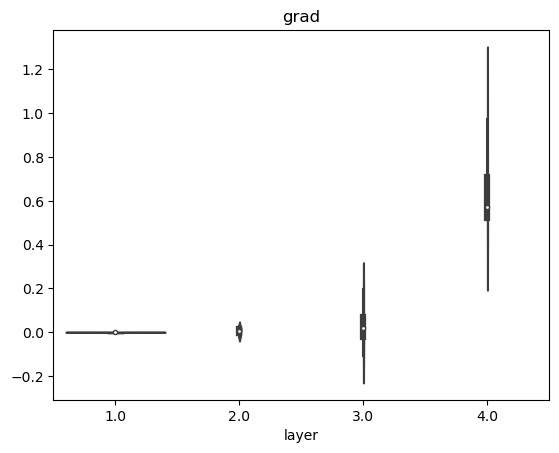

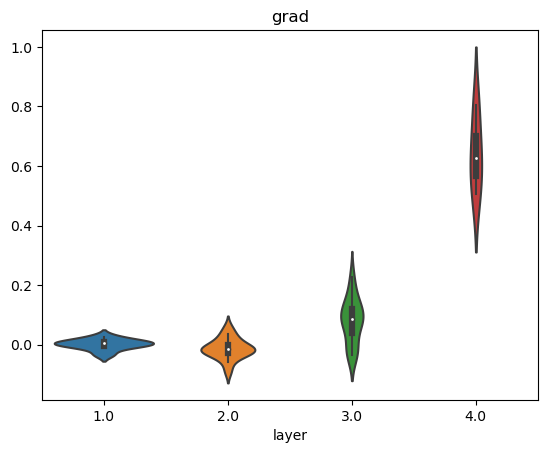

In [8]:
# 观察各层梯度值
# 设置超参数
lr = 0.03
num_epochs = 5

# 实例化模型
sigmoid_lr_l3 = L3SigmoidLR()
sigmoid_lr_l3_norm = L3SigmoidLR()

# Xavier初始化
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
for module in sigmoid_lr_l3_norm.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 迭代训练
train_losses, test_losses = train_test_model(sigmoid_lr_l3, train_loader, test_loader, lr=lr, num_epochs=num_epochs)
train_losses_norm, test_losses_norm = train_test_model(sigmoid_lr_l3_norm, train_loader_norm, test_loader_norm, lr=lr,
                                                       num_epochs=num_epochs)

# 绘制梯度的小提琴图
violin_plot_layers(sigmoid_lr_l3)
violin_plot_layers(sigmoid_lr_l3_norm)

通过微观层面、通过查看各层梯度值来观察数据归一化的效果，验证归一化是否有助于各层梯度保持平稳，由结果能看出，使用归一化后的数据进行建模的模型，前几轮迭代时梯度相对平稳，当各层梯度更加均衡时模型学习能力更强，进而能够加快模型收敛速度，甚至提升模型准确率。因此可以推断，**归一化是通过维持梯度平稳来加快收敛速度、提升模型准确率的**，而非归一化能够一定程度上消除数据偏移问题。这里统一先对模型进行Xavier参数初始化计算然后再使用数据归一化方法，是为了避免不同随机数种子对参数初始化取值的影响，但实际上参数初始化与数据归一化很少同时使用，并且神经网络用到的归一化方法在最终效果上基本上都能让模型摆脱参数初始化的限制，也就是能够让模型在不使用初始化方法的情况下仍然可以进行快速和稳定的收敛。

Epoch: 100%|██████████| 40/40 [00:01<00:00, 22.82it/s]


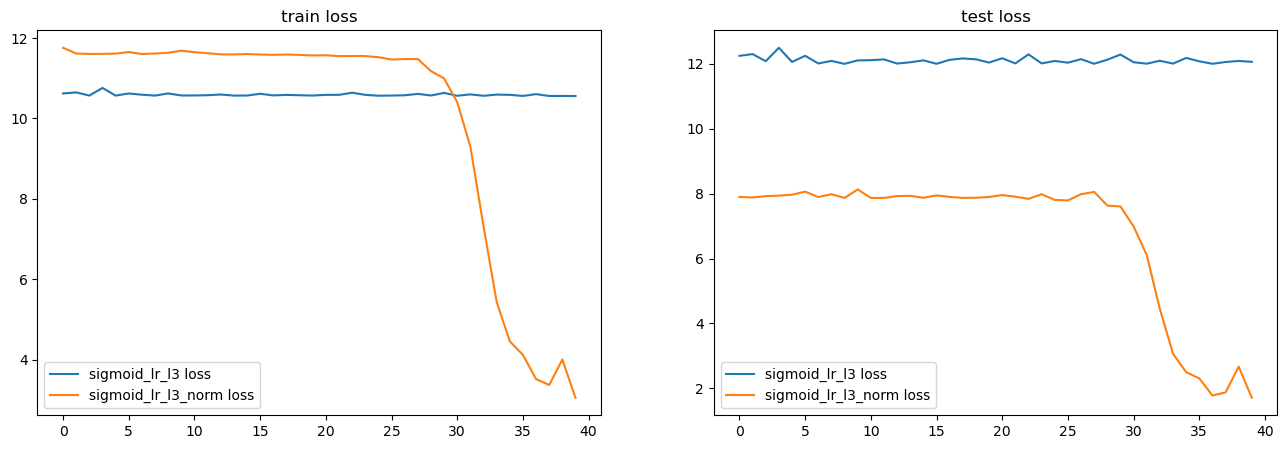

In [9]:
# 设置超参数
num_epochs = 40

# 重新实例化模型
sigmoid_lr_l3 = L3SigmoidLR()
sigmoid_lr_l3_norm = L3SigmoidLR()

# 重新Xavier初始化
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
for module in sigmoid_lr_l3_norm.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 迭代训练
train_losses, test_losses = train_test_model(sigmoid_lr_l3, train_loader, test_loader, lr=lr, num_epochs=num_epochs)
train_losses_norm, test_losses_norm = train_test_model(sigmoid_lr_l3_norm, train_loader_norm, test_loader_norm, lr=lr,
                                                       num_epochs=num_epochs)

# 绘制2个模型的损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(num_epochs), train_losses, label='sigmoid_lr_l3 loss')
plt.plot(range(num_epochs), train_losses_norm, label='sigmoid_lr_l3_norm loss')
plt.title('train loss')
plt.legend()
plt.subplot(122)
plt.plot(range(num_epochs), test_losses, label='sigmoid_lr_l3 loss')
plt.plot(range(num_epochs), test_losses_norm, label='sigmoid_lr_l3_norm loss')
plt.legend()
plt.title('test loss')
plt.legend()
plt.show()

从运行结果能够看出，经过Z-Score归一化的数据收敛速度更快，在很多情况下也能获得更好的结果。
### Z-Score归一化的局限性
在实际神经网络建模过程中，Z-Score的使用还是存在很多局限，具体来说主要如下：

（1）**数据的Zero-Centered特性消失**
尽管Z-Score归一化能够一定程度保证梯度平稳，进而提升模型收敛速度甚至是提升模型效果，但是，和Xavier初始化方法一样，由于只是对于“初始值”的修改，因此也会存在随着迭代次数增加就逐渐破坏了Zero-Centered Data这一条件的问题，这也是经典机器学习归一化方法应用于深度神经网络时的局限。同时，随着参数和输入数据都回到不可控状态，各层的梯度又将回到不可控的状态，因此梯度的梯度平稳性也难以得到保证。

下面创建相对梯度容易不平稳的Tanh激活函数模型，查看迭代5轮和50轮时各层梯度变化情况。

Epoch: 100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


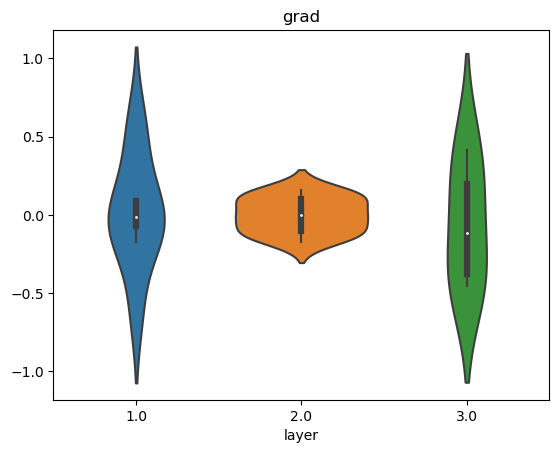

Epoch: 100%|██████████| 45/45 [00:01<00:00, 22.57it/s]


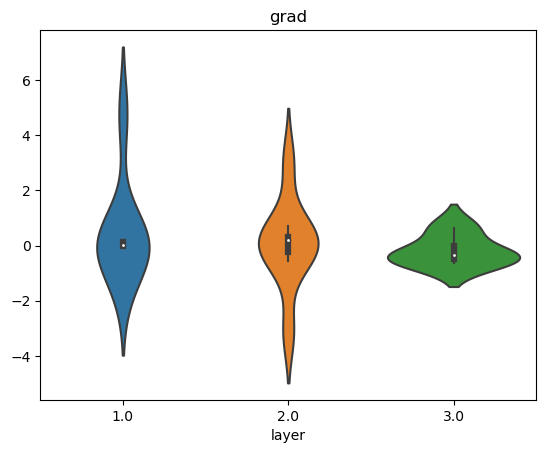

In [10]:
# 实例化模型
tanh_lr_l2 = L2TanhLR()

# Xavier初始化
for module in tanh_lr_l2.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 训练5轮
train_test_model(tanh_lr_l2, train_loader_norm, test_loader_norm, num_epochs=5)
# 可视化梯度
violin_plot_layers(tanh_lr_l2)

# 再训练45轮
train_test_model(tanh_lr_l2, train_loader_norm, test_loader_norm, num_epochs=45)
# 可视化梯度
violin_plot_layers(tanh_lr_l2)

可以看到，刚开始时梯度较为平稳，而迭代到后期时就出现了明显的梯度爆炸现象。

（2）Zero-Centered Data的作用局限性
除了输入数据在迭代过程中会逐渐丧失Zero-Centered特性外，Z-Score标准化在应用到深度学习模型时Zero-Centered Data本身的作用范围也是有限的，即使能够维持输入数据的Zero-Centered特性，也很难保证只凭借这一点就能一定确保梯度平稳。深度学习中保证各层梯度平稳是确保模型能够顺利有效进行学习的关键，梯度平稳可以用Glorot条件来进行描述，即正向传播过程中数据流经各层时输入和输出数据方差相同，反向传播时数据流经各层前后该层梯度的方差相同。零均值数据的良好特性归根结底还是因为零均值数据在各层梯度计算过程中，可以使得激活函数导函数输出结果尽可能大（ReLU激活函数时能够避免Dead ReLU Problem），从而确保梯度计算的有效性。

由于各层的梯度实际上受到激活函数、各层输入数据和参数三者共同影响，因此即使将所有的输入数据都调整为零均值，各层梯度的计算结果还是有可能因为受到其他因素影响导致不平稳，因此，一味追求输入数据的Zero-Centered或许并不是最好的选择。
## 2.Batch Normalization基础
### 通过调整输入数据保证梯度平稳——Batch Normalization
尽管Z-Score作用有限，但对输入数据进行有效处理依然是深度学习模型优化至关重要的方向。影响梯度平稳性的核心因素有三个：各层的参数；各线性层接收到的数据；激活函数。参数的优化方面，是通过Glorot条件巧妙设置参数初始值，从而使得各层梯度在计算过程中尽可能更加平稳。但由于参数本身的特殊性，我们只能设置其初始值，一旦模型开始迭代，参数就将开始“不受控制”的调整，初始值的设置是很难保证梯度长期平稳，这点和Z-Score对数据进行初始化存在的问题一致。激活函数选择方面，可以选择一些新兴的激活函数。输入数据的优化方面，目前来看，应用最为广泛、并且被验证的实践效果最好的数据归一化方法，是由Sergey loffe和Christian Szegedy在2015年发表的[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://de.arxiv.org/pdf/1502.03167)中提出的一种方法，该方法通过修改每一次带入训练的数据分布（每一个Batch）的数据分布，来提升模型各层梯度的平稳性，从而提升模型学习效率、提高模型训练结果。由于是修改每一个Batch的数据分布，因此该方法也被称为Batch Normalization（BN），即小批量数据归一化方法。根据论文中的观点，作者认为在深度神经网络模型训练过程中，容易出现内部协方差偏移（Internal Covariate Shift、ICS）问题，该问题会导致模型性能下降，而为了解决该问题，作者提出了BN方法，并在各种实验中验证了BN对模型效果提升的有效性。

需要注意，尽管BN也是一种数据归一化方法，但深度学习领域的归一化方法和经典机器学习的归一化方法却存在很大区别：经典机器学习的归一化方法主要是为了消除不同特征的量纲影响而对各列的数据分布进行修改，并且并非所有机器学习模型都要采用数据归一化方法才能进行有效建模；深度学习归一化方法的目标则是为了确保模型能够进行有效训练为目的，是一种适用于所有模型的一种必要的优化方法。同时，尽管BN是一种针对小批数据的数据归一化方法，但我们不能将其简单想象成就是针对每个小批数据进行类似传统机器学习的归一化操作，并且在使用层面也会相对更复杂。

后来又研究提出BN的理论基础不成立，即BN未解决ICS问题，但BN在应用实践中效果很好，有理论推断认为，BN之所以有效，可能是和修改数据分布、从而使得梯度更加平稳有关，即该方法之所以能够发挥作用，很有可能是因为满足了Glorot条件。深度学习作为“实证型”技术，在很多时候模型效果才是首要考虑因素，因此类似BN这种，虽然理论基础不成立，但实践效果很好的方法在深度学习领域是广泛存在的。
### 归一化方法与数据分布的相互独立性
任何归一化的本质都是对数据进行平移和放缩：平移，就是指数据集每一列统一加上或减去某一个数，在Z-Score中就是每一列减去该列的均值；放缩，就是指数据集中每一列数据统一除以或乘以某一个数，在Z-Score中就是每一列除以当前列的标准差。数据的平移和放缩是不会影响数据特征的分布情况的。

下面进行简单验证。

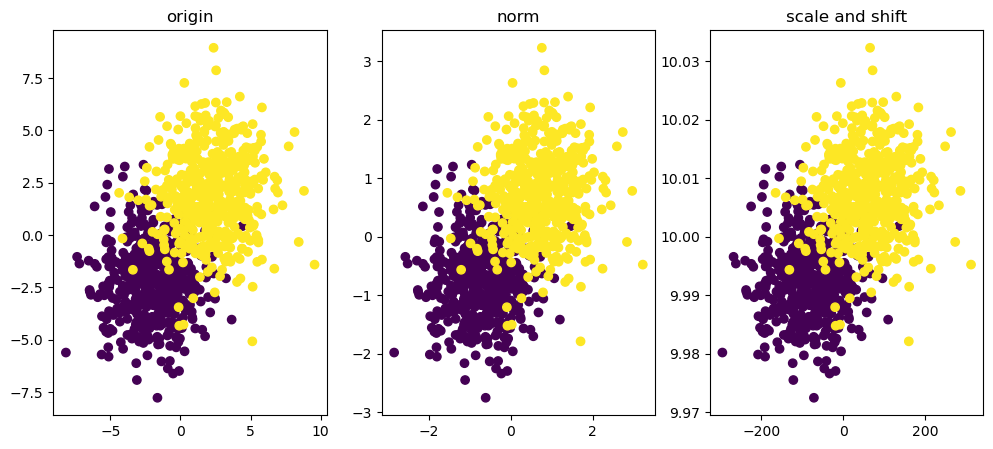

In [11]:
# 生成分类数据
features, labels = gen_cls_data()

# 查看原始数据分布
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.title('origin')

# 归一化数据
features_norm = z_score_norm(features)
plt.subplot(132)
plt.scatter(features_norm[:, 0], features_norm[:, 1], c=labels)
plt.title('norm')

# 任意平移和放松数据
plt.subplot(133)
plt.scatter(features_norm[:, 0] * 100 - 10, features_norm[:, 1] * 0.01 + 10, c=labels)
plt.title('scale and shift')

plt.show()

归一化前后数据分布不变，但数据在空间中的坐标的绝对值发生变化。同时，对原始数据进行任意的平移和放缩也不会改变原数据的分布。

数据的分布其实就代表着数据背后的规律，我们使用模型去捕捉数据规律，其实就是对数据分布情况进行学习。因此，数据归一化不修改数据分布，是我们使用归一化方法的基本前提，否则，一旦数据归一化方法会修改数据分布，则相当于是人为破坏了数据原始规律，这将会对后续的模型学习造成巨大的影响，因此在任何情况下机器学习建模都应避免人为修改数据规律。
### 归一化与仿射变换
归一化的本质仍然是对数据进行仿射变换。数据的仿射变换用矩阵形式来进行表示是
$$\hat x = x * w + b$$
其中x是原数据，w是参数矩阵、b是截距、$\hat x$是经过变换之后的数据。
进行归一化时的操作如下：
$$\frac{x-mean(x)}{std(x)}$$
转化为：
$$\frac{x}{std(x)} - \frac{mean(x)}{std(x)} = x \cdot\frac{1}{std(x)}- \frac{mean(x)}{std(x)} = x \otimes \gamma + \beta$$
其中，$\otimes$表示逐个元素相乘，$\gamma$和$\beta$都是参数，转换即得到了仿射变换的形式。
以Z-Score为例，探讨归一化操作转化为仿射变换的方法。

In [12]:
# 生成数据
feature = torch.randint(1, 21, (6, 3), dtype=torch.float)
# 对数据归一化
feature_norm = z_score_norm(feature)
feature, feature_norm

(tensor([[ 5.,  7.,  1.],
         [12.,  4.,  7.],
         [ 9.,  2.,  1.],
         [19., 19., 10.],
         [ 8.,  6., 16.],
         [17., 15.,  6.]]),
 tensor([[-1.3453, -0.3008, -1.1197],
         [ 0.0673, -0.7931,  0.0320],
         [-0.5381, -1.1213, -1.1197],
         [ 1.4799,  1.6683,  0.6079],
         [-0.7399, -0.4649,  1.7596],
         [ 1.0763,  1.0119, -0.1600]]))

In [13]:
# 参数gamma和beta
gamma = 1 / feature.std(0)
beta = -feature.mean(0) / feature.std(0)
gamma, beta

(tensor([0.1842, 0.1498, 0.1752]), tensor([-2.1492, -1.3232, -1.1974]))

In [14]:
# 归一化转换后的公式
feature * gamma + beta  # 与feature_norm结果一致

tensor([[-1.2281, -0.2746, -1.0222],
        [ 0.0614, -0.7240,  0.0292],
        [-0.4913, -1.0236, -1.0222],
        [ 1.3509,  1.5229,  0.5549],
        [-0.6755, -0.4244,  1.6063],
        [ 0.9825,  0.9237, -0.1460]])

可以看到，在归一化的过程中：放缩的部分可以通过矩阵乘法来完成；平移部分可以通过矩阵加法来解决。归一化是一种放射变换，并且归一化的计算过程可以用矩阵运算来完成，这会带来一些直接影响：
1. PyTorch中对数据的仿射变换是用线性层完成的，既然归一化是一种特殊的仿射变换，归一化的操作也可以看成一个特殊的线性层，并且和所有的线性层一样，归一化层也可以放置在任何隐藏层前后，这极大拓展了归一化操作可以出现的位置。在经典机器学习领域，对数据的归一化只停留在输入数据时对数据进行统一处理，但在深度学习中，如果只对初始输入数据进行归一化，那么在迭代过程中数据会逐渐失去初始化之后所带来的良好特性，此时如果我们可以像添加线性层一样，在任意隐藏层前后添加归一化层，则可以在迭代的每个环节对数据进行归一化，如此一来就能避免迭代过程中数据逐渐偏移所导致的梯度不平稳问题。
2. 在具体实现层面上，在仿射变换中可以设置参数、并且通过构建损失函数再利用梯度下降进行求解，那么对于归一化这种特殊的仿射变换，平移和放缩的尺度也可以简单设计成一个参数，然后带入模型进行训练求解：将数据转化为Zero-Centered Data并非最好的选择，如果可以通过梯度下降求解出最佳放缩和平移的尺度，大概率会比简单使用Z-Score将其放缩为均值为0、方差为1的数据分布效果更好（至少不会差）。

实际上BN也是这么做的：在BN中，以每次输入的小批数据为训练数据，我们将平移和放缩的尺度视作参数，通过带入模型进行训练，最终得出最佳平移和放缩尺度，并且这种BN归一化层可以视作添加了一层特殊的线性层来进行计算，可以出现在任意隐藏层的前后，为数据传输的每一步进行归一化操作。同时因为仿射变换之间可以进行叠加得到新的仿射变换，因此邻近的BN层和线性层进行融合在理论上和实践上也是可行的，通过两者的融合可以进一步优化BN层的执行效率。将平移和放缩的尺度视为参数，表明不是朝着零均值的方向去进行归一化处理，实际上在参数化尺度的时候，参数迭代的方向自然就变成了尽量保持各层梯度平稳，这也是参数化归一化尺度的有效性的最佳证明。同时，均值为0、方差为1的归一化却是也不一定是最优选择，根据梯度计算公式就可以看出，最佳的数据归一化方法并不是绝对的0均值、1方差，而是能够使得最终各变量相乘之后梯度保持均衡。
### Batch Normalization基本流程
作为一种数据归一化方法，Batch Normalization的理论实现流程看似复杂，但和所有的归一化方法一样，BN做的也就是对输入数据进行平移和放缩，只不过BN的平移和放缩分为两个阶段，具体如下：

（1）Z-Score放缩

将输入数据的均值平移至0、方差放缩至1。公式如下：
$$
\mu_B = \frac{1}{m_B}\sum^{m_B}_{i=1}x^{(i)} \\
\delta^2_B=\frac{1}{m_B}\sum^{m_B}_{i=1}(x^{(i)}-\mu_B)^2 \\
\hat{x}^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}}
$$
其中$\mu_B$代表输入的小批数据均值、$\delta^2_B$代表输入的小批数据方差、$\hat{x}$代表Z-Score归一化后的数据结果，Z-Score计算过程为减去每一列的元素减去该列的均值除以该列的修正后的标准差（方差加上一个极小的数使得其不为零），第1阶段的参数都是可以计算或者人工设置的，其中均值和方差都是简单计算即可得出，修正项$\epsilon$则可以手动设置。

（2）带参数的平移和放缩

在（1）的基础上，对数据的方差进行参数放缩，并对其均值进行参数平移，都是通过训练、也就是梯度下降算法算得的参数。公式如下：
$$z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta$$
和第1阶段参数可以简单计算得出不同，第2阶段的参数$\gamma$和$\beta$都是模型参数，在实际模型训练过程中是作为模型整体参数的一部分，带入损失函数、通过梯度下降计算得出的，数据处理过程是首先对一阶段放缩之后每一列的$\hat{x}$乘以一个固定的$\gamma$再加上一个固定的$\beta$。

BN两个阶段之间的关系：

经过分析可知，实际上BN的第1阶段和第2阶段都是在做同一件事，即都是在对数据进行平移和放缩，从理论上来说，可以将上述2个阶段合并为：
$$\begin{aligned}
z^{(i)}
& = \gamma \otimes \hat{x}^{(i)}+\beta \\
& = \gamma \otimes \frac{x^{(i)}-\mu_B}{\sqrt{\delta^2_B+\epsilon}} + \beta \\
& = \frac{\gamma}{\sqrt{\delta^2_B+\epsilon}}\otimes x^{(i)}+(\beta-\frac{\gamma \cdot \mu_B}{\sqrt{\delta^2_B+\epsilon}}) \\
& = \hat\gamma \otimes {x}^{(i)}+\hat \beta \\
\end{aligned}
$$
但是在实际建模过程中还是选择了2个阶段的方式，PyTorch模型训练完成后输出的参数结果也是原始的$\gamma$和$\beta$：一方面，BN方法增加了模型计算量，而提前对数据进行Z-Score处理就相当于是先选择了一组初始的$\gamma$和$\beta$对数据进行处理（此时$\gamma_0=\frac{1}{\sqrt{\delta^2_B+\epsilon}}, \beta_0 = \frac{-\mu_B}{\sqrt{\delta^2_B+\epsilon}}$），使得第1阶段处理后的数据保持了Zero-Centered的特性，而第2阶段进行带参数的平移和缩放，通过梯度下降得到的最优参数下的归一化后的数据也基本上会在零均值附近变化，因此第1阶段得到的$\gamma_0和\beta_0$离优化目标的距离会比较近，即第2阶段平移和缩放选择在$\gamma_0和\beta_0$基础上进行梯度下降计算，就相当于选择了一组初始值点，而该初始值点能够降低迭代次数、减少计算量，同时有效提升迭代收敛速度；另一方面，这种方式会计算每个Batch上的均值和方差，通过计算和处理可以累计得到在整个训练集上的均值和方差，从而使用训练集的均值和方差对测试集进行归一化，并进行模型在测试集上的评估。

BN有两种特殊情况：（1）当$\gamma = 1, \beta=0$时，上述过程就退化为Z-Score变换；（2）当$\gamma=\sqrt{\delta^2_B+\epsilon}, \beta=\mu_B$时，就相当于退回原始数据集，没有做任何处理。
### Batch Normalization方法有效性简析
一方面，一旦$\gamma$和$\beta$训练完成，经过BN处理完的数据将朝向标准差为$\gamma$、均值为$\beta$的分布方向靠拢，即BN作为一种特殊的仿射变换，会调整经过BN层的数据分布，而数据分布的均值和方差又是由模型训练得到的，并不一定像Z-Score一样是调整为0均值1方差的数据分布，因此BN在调整数据分布时其实是朝着最有利于提升模型效果的方向调整，也就是朝着满足损失函数能取得更小数值的方向调整。在这个过程中，调整后的数据分布可以以任何形态呈现，并不局限于0均值和1方差的数据分布，这也是BN方法和Z-Score方法最核心的区别。
另外，对数据进行归一化处理，也就是放缩和平移，其实是不会改变数据分布规律的，因此可以在模型训练的任何时候、任意阶段对数据进行放缩和平移，而BN方法本身又是一种数据分布自适应的方法，可以根据实际情况训练出最合适的数据分布，因此可以将BN方法放置于神经网络的各个线性层前后，协助模型即时调整数据在每一层的分布。如果这种**自适应的数据分布调整**是朝向损失函数取值更小的方向调整，并且数据分布直接影响的就是各线性层的梯度平稳性，而梯度平稳又是保证模型有效性的根本原因之一，由此可以得出这种数据分布上的自适应的调整确实是朝向保证模型梯度平稳的方向调整的。
### Batch Normalization的训练和测试
对于传统机器学习的归一化方法来说，在训练集上进行训练、在测试集上进行测试的流程相对比较清晰，用于测试集归一化的参数是从训练集当中计算而来的，也就是说在对测试集进行归一化时，均值和方差都是训练集中数据计算结果。对于BN方法来说，由于其方法是针对每一个小批数据进行归一化，并且计算过程也是使用了整体均值和方差的无偏估计，尽管当模型训练完成时将算出$\gamma$和$\beta$的值，但当带入测试数据进行向前传播时，均值和方差仍然是需要重新计算的，这是因为测试集可能是一条条数据进来，因此不能使用测试集的均值和方差对整体进行无偏估计，为解决该问题，BN方法一般都会配套一个记录训练数据整体均值和方差的方法，并且为了做到训练阶段和测试阶段使用不同的计算方式，PyTorch中的BN实现还涉及到了模型状态切换。

## 3.Batch Normalization在PyTorch中的实现——nn.BatchNorm类
### nn.BatchNorm类介绍
在PyTorch中，使用nn.Linear构建线性层，相似地，通过使用nn.BatchNorm类来构建BN层，进行Batch Normalization归一化操作，BN层和线性层之间由诸多相似之处。同时，BatchNorm有不同的类型：nn.BatchNorm1d类主要用于处理2d数据，nn.BatchNorm2d则主要用来处理3d数据，等等。面板数据（二维表格数据）都属于2d数据，使用nn.BatchNorm1d处理，处理图像数据时，则需要视情况和使用nn.BatchNorm2d类。
nn.BatchNorm1d类的3个核心参数如下：
- num_features：输入数据的特征数量（假设为n），也就是前一层神经元数量或原始数据集特征数量
- eps：方差分母修正项，为了防止分母为0，默认值为1e-5
- affine：是否进行仿射变换，进行仿射变换时使用无偏估计进行期望和方差的计算，并且初始条件下$\gamma=1，\beta=0$：当参数取值为True时，会显式设置$\gamma$和$\beta$参数并带入进行梯度下降迭代计算；取值为False时，参数不显示，实际的数据归一化过程就是对原数据进行无偏估计下的Z-Score变换

简单使用如下。

In [15]:
feature = torch.randint(1, 21, (6, 3), dtype=torch.float)
feature

tensor([[13., 14., 12.],
        [14., 20.,  9.],
        [14., 10., 14.],
        [16., 20.,  3.],
        [13.,  7.,  2.],
        [ 9., 10.,  5.]])

In [16]:
# 实例化BN类
bn = nn.BatchNorm1d(3)
bn(feature)  # BatchNorm结果

tensor([[-0.0788,  0.0995,  1.0000],
        [ 0.3941,  1.2935,  0.3333],
        [ 0.3941, -0.6965,  1.4444],
        [ 1.3398,  1.2935, -1.0000],
        [-0.0788, -1.2935, -1.2222],
        [-1.9703, -0.6965, -0.5556]], grad_fn=<NativeBatchNormBackward0>)

In [17]:
print((feature - feature.mean(0)) / feature.std(0))  # PyTorch方差默认采用样本无偏估计
print((feature - feature.mean(0)) / feature.std(0, unbiased=False))  # BN归一化计算结果，方差采用样本方差

tensor([[-0.0719,  0.0908,  0.9129],
        [ 0.3597,  1.1808,  0.3043],
        [ 0.3597, -0.6358,  1.3186],
        [ 1.2231,  1.1808, -0.9129],
        [-0.0719, -1.1808, -1.1157],
        [-1.7986, -0.6358, -0.5072]])
tensor([[-0.0788,  0.0995,  1.0000],
        [ 0.3941,  1.2935,  0.3333],
        [ 0.3941, -0.6965,  1.4444],
        [ 1.3398,  1.2935, -1.0000],
        [-0.0788, -1.2935, -1.2222],
        [-1.9703, -0.6965, -0.5556]])


可以看到，BN层采用的是样本方差，而PyTorch的默认方差计算方式是样本无偏估计，两者的区别如下：
样本方差为：
$$Var(x) = \frac{\sum^n_{i=1}(x_i-\bar x)^2}{n}$$
对样本整体方差的无偏估计为：
$$Var_{unbiased}(x) = \frac{\sum^n_{i=1}(x_i-\bar x)^2}{n-1}$$
具体是通过unbiased参数控制，两者的使用如下。

In [18]:
print(torch.std(feature, 0))  # 整体方差的无偏估计
print(torch.std(feature, 0, unbiased=False))  # 样本方差

tensor([2.3166, 5.5045, 4.9295])
tensor([2.1148, 5.0249, 4.5000])


In [19]:
# 查看BN层的参数
list(bn.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

In [20]:
list(bn.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

根据输出结果可以确定在迭代开始之前$\gamma$和$\beta$的初始值，即分别为1和0。同时根据参数的可微性，也能看出其最终也是需要通过反向传播计算梯度，然后利用梯度下降进行求解的。如果将affine参数设置为False，则无法查看参数，并且归一化过程就是简单的在无偏估计下对数据进行Z-Score归一化。

In [21]:
bn = nn.BatchNorm1d(3, affine=False)  # affine参数设为False
bn(feature)  # 此时输出不可微，无法进行反向传播，因此也无法更新BN层参数

tensor([[-0.0788,  0.0995,  1.0000],
        [ 0.3941,  1.2935,  0.3333],
        [ 0.3941, -0.6965,  1.4444],
        [ 1.3398,  1.2935, -1.0000],
        [-0.0788, -1.2935, -1.2222],
        [-1.9703, -0.6965, -0.5556]])

In [22]:
list(bn.parameters())  # 此时参数列表为空

[]

BN层有一个核心需要解决的问题：在测试阶段针对可能出现的一条条测试集输入的情况，应该如何对测试数据进行归一化处理。BN层采用了机器学习一以贯之的基本思路，那就是所有用于处理测试数据的参数都在训练数据中得出，即对于测试集在归一化过程中所用到的均值和方差，都是训练数据整体均值和方差。但是，在模型训练阶段，数据是分一个个小批输入的，而针对小批训练数据的归一化处理也没有采用所有训练数据的均值和方差，而是采用训练数据总体均值和方差的无偏估计带入进行计算。为了能够获取训练数据整体均值和方差，BN采用了迭代累计计算的方法，通过类似动量法的方法对每一个小批数据的均值和方差进行累计统计，最终计算训练数据整体均值和方差。

In [23]:
bn = nn.BatchNorm1d(3)
bn.running_mean, bn.running_var  # 记录的整个训练集的默认均值和方差，初始条件下，running_mean为0、running_var为1

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [24]:
bn(feature)  # 前向传播

tensor([[-0.0788,  0.0995,  1.0000],
        [ 0.3941,  1.2935,  0.3333],
        [ 0.3941, -0.6965,  1.4444],
        [ 1.3398,  1.2935, -1.0000],
        [-0.0788, -1.2935, -1.2222],
        [-1.9703, -0.6965, -0.5556]], grad_fn=<NativeBatchNormBackward0>)

In [25]:
# 数据的均值和方差
print(feature.mean(0), feature.var(0))
# 更新记录的均值和方差
bn.running_mean, bn.running_var  # 发生改变，向数据的均值和方差靠近

tensor([13.1667, 13.5000,  7.5000]) tensor([ 5.3667, 30.3000, 24.3000])


(tensor([1.3167, 1.3500, 0.7500]), tensor([1.4367, 3.9300, 3.3300]))

BN层在每一次进行归一化时，都会通过“某种”方法累计输入数据集的均值和方差，在每一次处理完一批数据之后，BN层的running_mean和running_var的值都会更新。BN层并不是记录输入数据集的均值和方差，而是采用了一种类似动量法的方法在累计每一个小批数据的统计量，过程如下：

（1）每次实例化一个BN层之后，都会获得一组原始的running_mean和running_var，分别为0和1；

（2）每一次使用BN层进行归一化数据时，BN层的running_mean和running_var都会按照公式进行调整：
$$
running\_mean = (1-momentum) * running\_mean + momentum * sample\_mean \\
running\_var = (1-momentum) * running\_var + momentum * sample\_var
$$
其中，momentum是BN层实例化过程中的可选参数，默认值为0.1，sample表示当前输入的小批数据。上述过程可简单理解为BN层每次归一化一批数据，都会针对围绕已经记录的running_mean/var和小批数据的sample_mean/var进行加权求和，此时**小批数据的均值和方差又采用了无偏估计**的方式，在momentum取值为0.1的情况下，原running_mean/var权重是sample_mean/var的9倍，也就是说，当前数据归一化完成后，running_mean/var会朝向sample_mean/var小幅移动。上面BN层的running_mean和running_var更新的手动计算如下。

In [26]:
bn = nn.BatchNorm1d(3)
print((1 - bn.momentum) * bn.running_mean + bn.momentum * feature.mean(0))
print((1 - bn.momentum) * bn.running_var + bn.momentum * feature.var(0))  # 与前面的结果一致

tensor([1.3167, 1.3500, 0.7500])
tensor([1.4367, 3.9300, 3.3300])


In [27]:
# 同一批数据进行多轮迭代
mean_list, var_list = [], []

for _ in range(100):
    bn(feature)
    mean_list.append(bn.running_mean.tolist())
    var_list.append(bn.running_var.tolist())

# 对比running_mean和数据的均值
bn.running_mean, feature.mean(0)  # 很接近

(tensor([13.1663, 13.4996,  7.4998]), tensor([13.1667, 13.5000,  7.5000]))

In [28]:
# 对比running_var和数据的方差
bn.running_var, feature.var(0)  # 也很接近

(tensor([ 5.3666, 30.2992, 24.2994]), tensor([ 5.3667, 30.3000, 24.3000]))

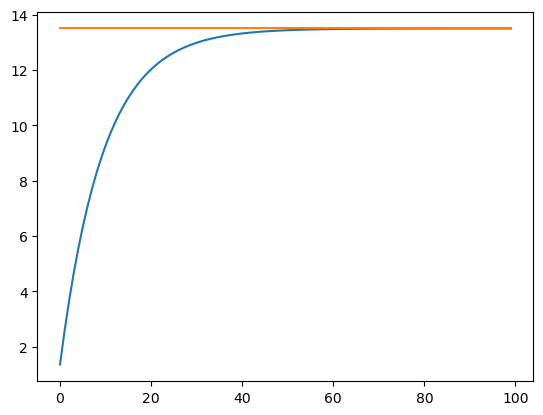

In [29]:
# 可视化BN层的running_mean变化情况
mean_tensor = torch.tensor(mean_list)
plt.plot(range(100), mean_tensor[:, 1], torch.full_like(mean_tensor[:, 1], feature.mean(0)[1]))
plt.show()  # running_mean逐渐逼近数据的均值的无线估计

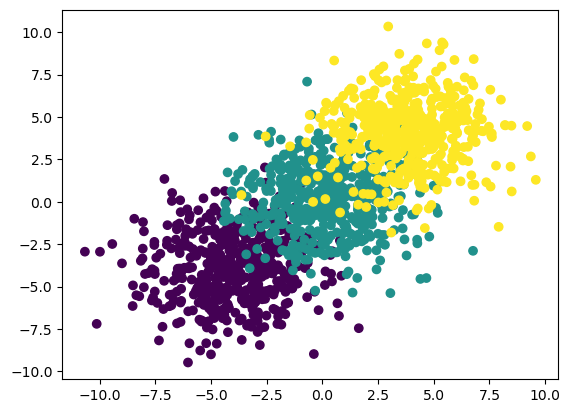

In [30]:
# 生成分类数据进行测试
features, labels = gen_cls_data(num_classes=3)

# 可视化数据整体分布
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.show()

In [31]:
# 数据集切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)
features_train = features[train_loader.dataset.indices]  # 训练集特征
features_train.shape

torch.Size([1200, 2])

In [32]:
# 查看训练集特征的均值和方差
features_train.mean(0), features_train.var(0)

(tensor([0.0135, 0.0029]), tensor([14.3442, 14.9218]))

In [33]:
# 实例化BN类
bn = nn.BatchNorm1d(2)
bn.running_mean, bn.running_var

(tensor([0., 0.]), tensor([1., 1.]))

In [34]:
# 在训练集上进行迭代多轮
for epoch in range(10):
    for inputs, labels in train_loader:
        bn(inputs)

# 再查看running_mean和running_var属性
bn.running_mean, bn.running_var  # 比较接近训练集特征的真实均值而方差

(tensor([0.2925, 0.0949]), tensor([13.4833, 12.9598]))

In [35]:
# 多迭代几轮
for epoch in range(40):
    for inputs, labels in train_loader:
        bn(inputs)

bn.running_mean, bn.running_var  # 进一步逼近训练集特征的真实均值而方差

(tensor([-0.0503,  0.1301]), tensor([14.8441, 15.6700]))

可以看到，BN记录结果是朝向训练集的整体真实结果靠拢。之所以BN层采用迭代方法求解训练集特征的均值和方差，而不是直接直接按列进行统计，主要是因为：（1）面对超大规模数据时候求解均值或方差可能无法直接进行求解，尤其是如果数据是分布式存储的话一次性求解均值和方差就会更加困难；（2）迭代计算是深度学习求解参数的基本过程，所有深度学习框架为了更好地满足迭代计算，都进行了许多精巧的设计，从而使得迭代计算更加高效和平稳，而在计算训练集整体均值时，如果借助神经网络向前传播的过程进行迭代记录，便能够在控制边际成本的情况下快速达成目标。

BN类的另外2个参数：
- momentum参数：一般来说，为了尽可能获取到更加准确的训练集整体统计量，当每一个小批数据数据量比较小时，我们应该将历史数据比重调高，也就是降低momentum取值，以减少局部规律对获取总体规律的影响，此时也需要增加遍历数据的次数epochs；反之则可以考虑增大momentum取值。
- track_running_stats参数：默认取值为True。当此参数为True时，BN层会在每次迭代过程中会结合历史记录更新running_mean/var；当track_running_stats=False时，BN层将running_mean/var为None，并且在预测时会根据输入的小批数据进行均值和方差计算。在大多数情况下，不推荐修改该参数的默认取值。

### 训练模式与测试模式
PyTorch提供了适用于nn模块中所有模型的一组方法，即`model.train()`与`model.eval()`：
- `model.train()`表示开启模型训练模式，默认情况下实例化的每一个模型都是处于训练模式的
- `model.eval()`则表示将模型转化为测试模式，也可以使用`model.train(False)`来关闭训练模式，即开启测试模式

在PyTorch中，其实有很多类和BN类类似，会在向前传播过程中直接自动修改模型参数，而当模型处于测试模式时，需要避免这种情况发生，即模型处于测试模式时不会根据当前输入数据情况调整特定参数（对于BN层来说就是running_mean/var）。并且，模型出于测试模式时，BN层会利用训练阶段记录下的running_mean/var对数据进行归一化。PyTorch中模型训练模式和测试模式的区分，相当于是给模型提供了可设置的两种行为模式，两种模式可以通过`training`属性来查看。同时，当模型（model）由多个模块（module）构成时，各模块的状态由模型整体状态决定。

In [36]:
# 简单使用
bn = nn.BatchNorm1d(3)
bn.train()  # 设置训练模式
bn.training

True

In [37]:
bn.eval()  # 设置测试模式，也可以用bn.train(False)实现同样的效果
bn.training

False

In [38]:
# 改回训练模式
bn.train(True)
bn.training

True

In [39]:
# 训练模式
bn = nn.BatchNorm1d(3)
bn.train()
print(bn.running_mean, bn.running_var)
# 前向传播
bn(feature)
print(bn.running_mean, bn.running_var)  # 更新running_mean和running_var的值
bn(feature)  # 使用样本的均值和方差进行归一化

tensor([0., 0., 0.]) tensor([1., 1., 1.])
tensor([1.3167, 1.3500, 0.7500]) tensor([1.4367, 3.9300, 3.3300])


tensor([[-0.0788,  0.0995,  1.0000],
        [ 0.3941,  1.2935,  0.3333],
        [ 0.3941, -0.6965,  1.4444],
        [ 1.3398,  1.2935, -1.0000],
        [-0.0788, -1.2935, -1.2222],
        [-1.9703, -0.6965, -0.5556]], grad_fn=<NativeBatchNormBackward0>)

In [40]:
# 测试模式
bn = nn.BatchNorm1d(3)
bn.eval()
print(bn.running_mean, bn.running_var)
# 前向传播
bn(feature)
print(bn.running_mean, bn.running_var)  # 不更新running_mean和running_var的值
bn(feature)  # 使用训练阶段得到的的running_mean和running_var作为均值和方差进行归一化（因为没有进行训练，所以均值为默认的0、方差为默认的1），所以相当于没有对数据进行处理

tensor([0., 0., 0.]) tensor([1., 1., 1.])
tensor([0., 0., 0.]) tensor([1., 1., 1.])


tensor([[12.9999, 13.9999, 11.9999],
        [13.9999, 19.9999,  9.0000],
        [13.9999, 10.0000, 13.9999],
        [15.9999, 19.9999,  3.0000],
        [12.9999,  7.0000,  2.0000],
        [ 9.0000, 10.0000,  5.0000]], grad_fn=<NativeBatchNormBackward0>)

### 构建带BN层的模型
BN本质上是一种自适应的数据分布调整算法，数据本身的分布并不受影响，因此可以在任何需要的位置都进行BN归一化。同时，根据Glorot条件，在模型构建过程中需要力求各梯度计算的有效性和平稳性，因此可以考虑在每一个线性层前面或者后面进行数据归一化处理。在实际模型构建过程中，在模型中添加BN层和添加线性层类似，只需要在自定义模型类的init方法中添加BN层，并在向前传播方法中调用BN层即可。而在具体BN层位置选择方面，是放在线性层前面还是放在线性层后面，并无定论，此时可以根据习惯和经验的判断选择BN层的位置。将放在隐藏层前面（也就是线性层后面）称为BN层前置，放在隐藏层后面称为BN层后置，实践时，可以通过参数控制BN层前置还是后置。下面创建一个同时能够调整激活函数、可选是否包含BN层、以及BN层放置位置的模型，可以更方便地实现各种模型。

In [41]:
# 2层神经网络、BN层可选、激活函数可选的模型
class L1LRWithBN(nn.Module):
    def __init__(self, activation=F.relu, in_features=2, hidden_dim=4, out_features=1, bias=True, bn_mode=None,
                 bn_momentum=0.1):
        super().__init__()
        self.linea1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.bn = nn.BatchNorm1d(hidden_dim, momentum=bn_momentum)
        self.linea2 = nn.Linear(hidden_dim, out_features, bias=bias)
        self.activation = activation
        self.bn_mode = bn_mode

    def forward(self, x):
        if self.bn_mode == 'pre':  # 前置BN
            out = self.bn(self.linea1(x))
            out = self.activation(out)
            out = self.linea2(out)
        elif self.bn_mode == 'post':  # 后置BN
            out = self.linea1(x)
            out = self.activation(out)
            out = self.linea2(self.bn(out))
        else:  # 不使用BN层
            out = self.linea1(x)
            out = self.activation(out)
            out = self.linea2(out)
        return out

In [42]:
# 创建数据
features, labels = gen_reg_data(w=[2, -1], bias=False, deg=2)
labels.unsqueeze_(-1)

# 数据切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)

# 实例化BN前置的模型
relu_lr_norm = L1LRWithBN(bn_mode='pre')
# 设置训练模式
relu_lr_norm.train()  # 默认模式
relu_lr_norm

L1LRWithBN(
  (linea1): Linear(in_features=2, out_features=4, bias=True)
  (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linea2): Linear(in_features=4, out_features=1, bias=True)
)

In [43]:
# 查看所有子模块的训练模式
{name: module.training for name, module in relu_lr_norm.named_modules() if name}  # 对模型整体设置训练模式后，模型中的所有子模块都被同步设置

{'linea1': True, 'bn': True, 'linea2': True}

In [44]:
# 设置测试模式
relu_lr_norm.eval()
{name: module.training for name, module in relu_lr_norm.named_modules() if name}  # 所有模块都被同步设置为测试模式

{'linea1': False, 'bn': False, 'linea2': False}

In [45]:
# 查看BN层的running_mean和running_var
relu_lr_norm.bn.running_mean, relu_lr_norm.bn.running_var

(tensor([0., 0., 0., 0.]), tensor([1., 1., 1., 1.]))

In [46]:
# 查看BN层的参数
relu_lr_norm.bn.weight, relu_lr_norm.bn.bias  # 对应gamma和beta

(Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True))

In [47]:
# 恢复成训练模式
relu_lr_norm.train()

# 超参数
lr = 0.03
num_epochs = 20

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(relu_lr_norm.parameters(), lr=lr)

# 迭代训练
fit(relu_lr_norm, criterion=criterion, optimizer=optimizer, data_loader=train_loader, num_epochs=num_epochs)

Epoch: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s]


In [48]:
# 再次查看BN层参数
relu_lr_norm.bn.weight, relu_lr_norm.bn.bias  # BN层确实得到了训练

(Parameter containing:
 tensor([2.0214, 2.0047, 2.3613, 2.0685], requires_grad=True),
 Parameter containing:
 tensor([-1.4326, -0.3867, -1.2757, -1.9710], requires_grad=True))

In [49]:
# 再次查看BN层的running_mean和running_var
relu_lr_norm.bn.running_mean, relu_lr_norm.bn.running_var  # 统计指标也得到了更新，同时可以看到，输入隐含层的数据基本上是零均值分布，印证了BN层的有效性

(tensor([-0.5276,  0.1206,  0.2465, -0.4388]),
 tensor([2.7763, 2.8259, 3.3961, 2.1696]))

In [50]:
# 测试模型
relu_lr_norm.eval()
loss_with_loader(relu_lr_norm, train_loader, criterion), loss_with_loader(relu_lr_norm, test_loader,
                                                                          criterion)  # 在训练集和测试集上的损失符合预期

(tensor(1.0816, grad_fn=<MseLossBackward0>),
 tensor(1.2949, grad_fn=<MseLossBackward0>))

In [51]:
# 再次查看BN层的running_mean和running_var
relu_lr_norm.bn.running_mean, relu_lr_norm.bn.running_var  # 未更新，说明测试模式生效

(tensor([-0.5276,  0.1206,  0.2465, -0.4388]),
 tensor([2.7763, 2.8259, 3.3961, 2.1696]))

Epoch: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


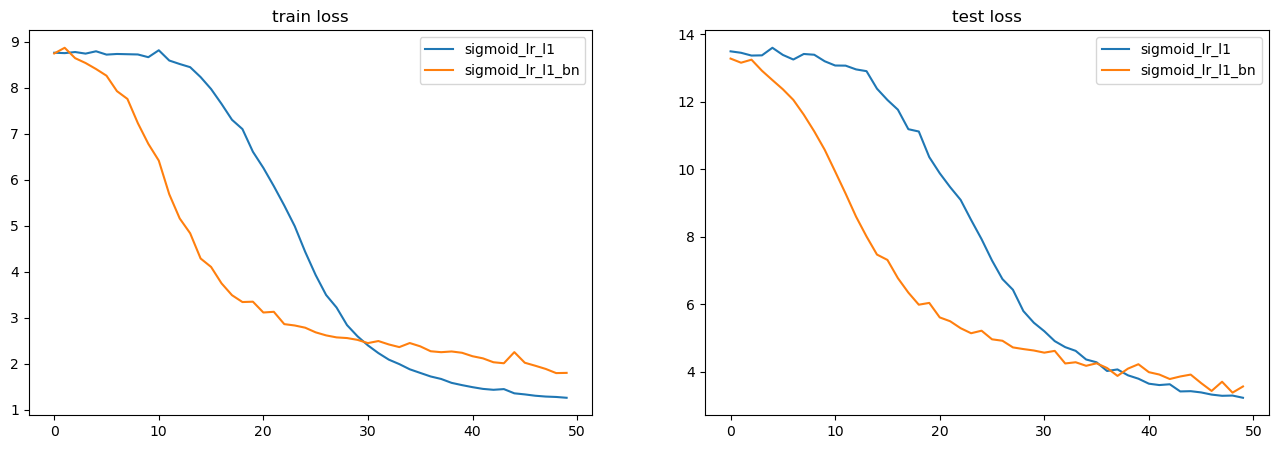

In [52]:
# 使用Sigmoid激活函数模型
# 实例化模型
sigmoid_lr_l1 = L1LRWithBN(activation=torch.sigmoid)
sigmoid_lr_l1_bn = L1LRWithBN(activation=torch.sigmoid, bn_mode='pre')

# 模型列表
model_list = [sigmoid_lr_l1, sigmoid_lr_l1_bn]
name_list = ['sigmoid_lr_l1', 'sigmoid_lr_l1_bn']

# 超参数
lr = 0.03
num_epochs = 50

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

可以看到，加入BN层之后，模型效果反而不如原始模型。不难得出，BN优化算法使用起来其实并不简单，并不是只要加入BN层模型效果就一定会有所提升，要充分发挥BN层的效果，需要结合其他模型参数进行综合调参。
## 3.Batch Normalization调参实战
带BN层的模型并不一定比不带BN层模型效果好，要充分发挥BN层的效果，就必须掌握一些调参理论和调参技巧。
### Batch Normalization与Batch_size综合调参
BN是一种在长期实践中被证明行之有效的优化方法，但BN的理论基础是以BN层能够有效预估输入数据整体均值和方差为前提的，如果不能尽可能的从每次输入的小批数据中更准确的估计整体统计量，则后续的平移和放缩也将是有偏的。而由小批数据估计整体统计量的可信度其实是和小批数据本身数量相关的，如果小批数据数量太少，则进行整体统计量估计时就将有较大偏差，此时会影响模型准确率，因此在使用BN时，应该使得小批数据量（batch_size）取值较大，至少需要保证在15-30以上，才能进行相对准确的预估。下面调整小批数据量参数，并进行模型计算。

In [53]:
# 重新划分数据集
train_loader, test_loader = split_load_data(GenDataset, features, labels, batch_size=64)  # 增大batch_size
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x27e199e1ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x27e199e1c10>)

Epoch: 100%|██████████| 200/200 [00:12<00:00, 16.67it/s]


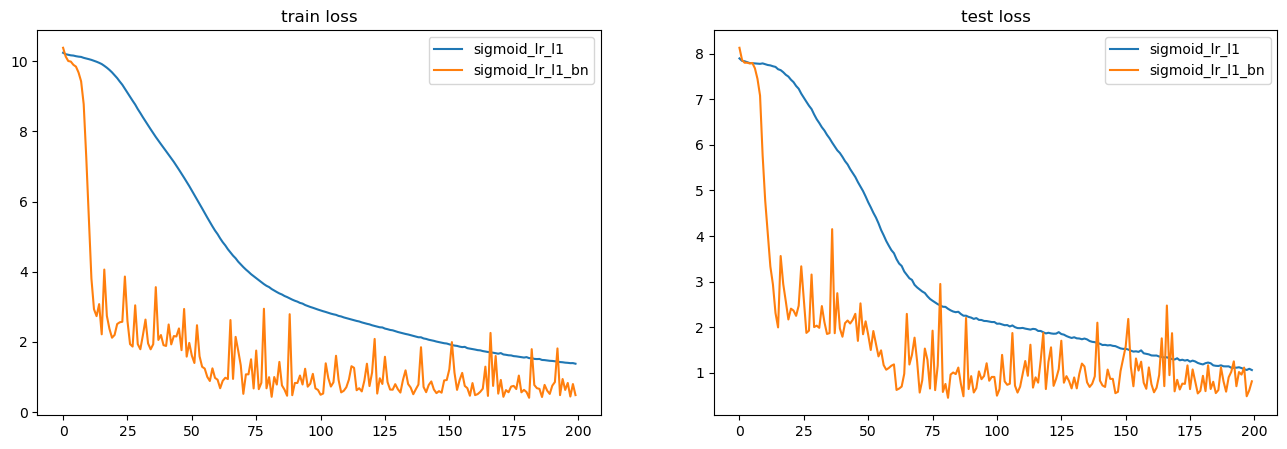

In [54]:
# 实例化模型
sigmoid_lr_l1 = L1LRWithBN(activation=torch.sigmoid)
sigmoid_lr_l1_bn = L1LRWithBN(activation=torch.sigmoid, bn_mode='post')

# 模型列表
model_list = [sigmoid_lr_l1, sigmoid_lr_l1_bn]
name_list = ['sigmoid_lr_l1', 'sigmoid_lr_l1_bn']

# 超参数
lr = 0.03
num_epochs = 200

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

当提升batch_size之后，带BN层的模型效果有明显提升，相比原始模型，带BN层的模型拥有更快的收敛速度和更好的模型效果。同时，引入BN层，也带来了不稳定性，模型的效果波动更加剧烈。为了确保BN层对整体统计量估计的可信度，除了提高batch_size之外，还能通过调低momentum参数来实现，当然，伴随着momentum值的降低，也必须进一步提升遍历数据集的次数，实现如下。

Epoch: 100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


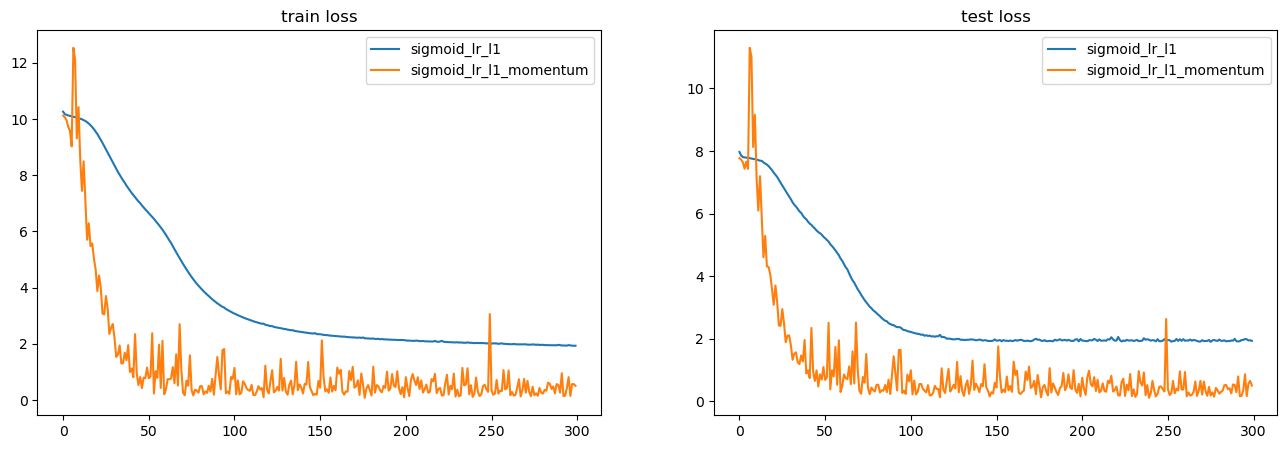

In [55]:
# 实例化模型
sigmoid_lr_l1 = L1LRWithBN(activation=torch.sigmoid)
sigmoid_lr_l1_momentum = L1LRWithBN(activation=torch.sigmoid, bn_mode='post', bn_momentum=0.01)

# 模型列表
model_list = [sigmoid_lr_l1, sigmoid_lr_l1_momentum]
name_list = ['sigmoid_lr_l1', 'sigmoid_lr_l1_momentum']

# 超参数
lr = 0.03
num_epochs = 300

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 减小momentum，模型效果变好，同时加快收敛，但是不稳定性依然很大

### 复杂模型上的Batch Normalization表现
一般来说，BN方法对于复杂模型和复杂数据会更加有效，因此很多简单模型是没必要使用BN层，因为这只是徒增计算量。对于上面的模型来说，由于只存在一个隐藏层，因此也不会存在梯度不平稳的现象，BN层的优化效果也并不明显，复杂模型带上BN层之后会有更大的优化空间。下面尝试设置更加复杂的数据集，同时增加模型复杂度，测试在更加复杂的环境下BN层表现情况。

In [56]:
# 生成更复杂的数据集：y=2x1^2-x2^2+3x3^2+x4^2+2x5^2
features, labels = gen_reg_data(w=(2, -1, 3, 1, 2), deg=2, bias=False)
labels.unsqueeze_(-1)
# 划分数据集
train_loader, test_loader = split_load_data(GenDataset, features, labels, batch_size=64)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x27e20857490>,
 <torch.utils.data.dataloader.DataLoader at 0x27e20857580>)

In [57]:
# 使用带1-4层Sigmoid的模型，对比带BN和不带BN的模型效果
# 超参数
lr = 0.01
num_epochs = 200

# 1层Sigmoid
sigmoid_lr_l1 = L1LRWithBN(in_features=5, activation=torch.sigmoid)
sigmoid_lr_l1_norm = L1LRWithBN(in_features=5, activation=torch.sigmoid, bn_mode='pre')

# 模型列表
model_list = [sigmoid_lr_l1, sigmoid_lr_l1_norm]
name_list1 = ['sigmoid_lr_l1', 'sigmoid_lr_l1_norm']

# 迭代训练
train_losses1, test_losses1 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 2层Sigmoid
sigmoid_lr_l2 = L2LRWithBN(in_features=5, activation=torch.sigmoid)
sigmoid_lr_l2_norm = L2LRWithBN(in_features=5, activation=torch.sigmoid, bn_mode='pre')

# 模型列表
model_list = [sigmoid_lr_l2, sigmoid_lr_l2_norm]
name_list2 = ['sigmoid_lr_l2', 'sigmoid_lr_l2_norm']

# 迭代训练
train_losses2, test_losses2 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 3层Sigmoid
sigmoid_lr_l3 = L3LRWithBN(in_features=5, activation=torch.sigmoid)
sigmoid_lr_l3_norm = L3LRWithBN(in_features=5, activation=torch.sigmoid, bn_mode='pre')

# 模型列表
model_list = [sigmoid_lr_l3, sigmoid_lr_l3_norm]
name_list3 = ['sigmoid_lr_l3', 'sigmoid_lr_l3_norm']

# 迭代训练
train_losses3, test_losses3 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 4层Sigmoid
sigmoid_lr_l4 = L4LRWithBN(in_features=5, activation=torch.sigmoid)
sigmoid_lr_l4_norm = L4LRWithBN(in_features=5, activation=torch.sigmoid, bn_mode='pre')

# 模型列表
model_list = [sigmoid_lr_l4, sigmoid_lr_l4_norm]
name_list4 = ['sigmoid_lr_l4', 'sigmoid_lr_l4_norm']

# 迭代训练
train_losses4, test_losses4 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

Epoch: 100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


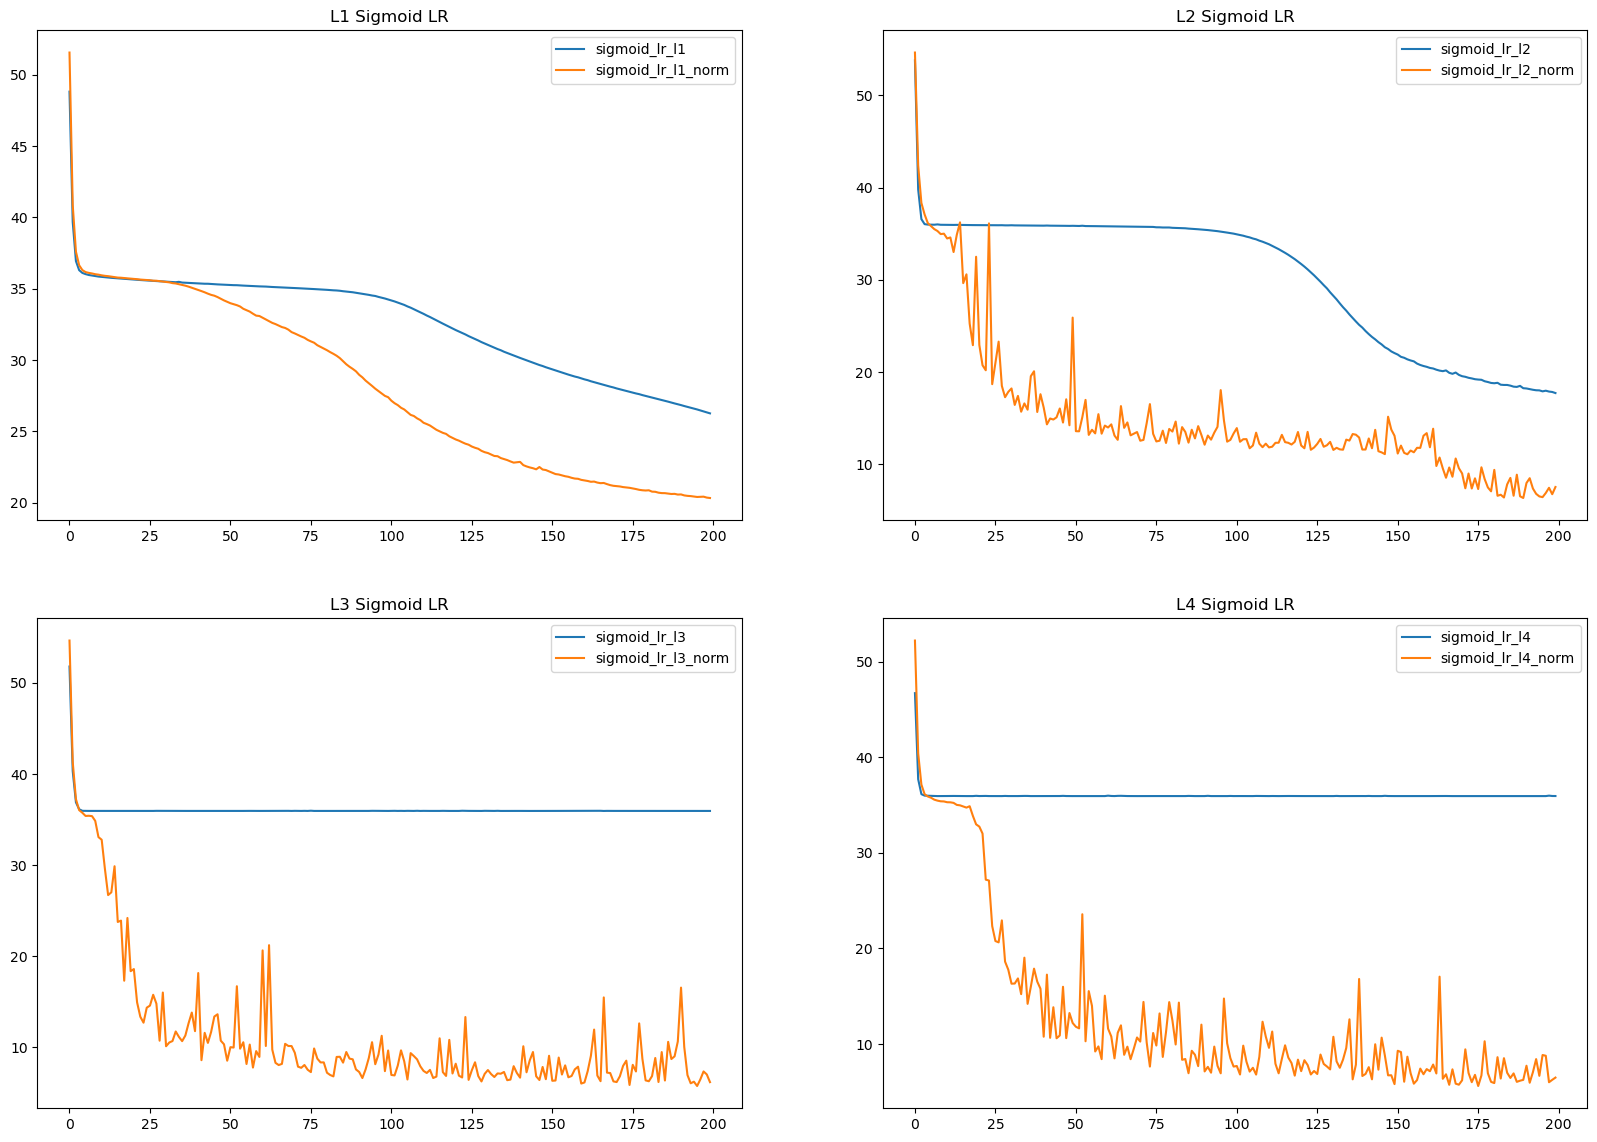

In [58]:
# 绘制训练集损失图像
plt.figure(figsize=(20, 14))
plt.subplot(221)
for idx, name in enumerate(name_list1):
    plt.plot(range(num_epochs), train_losses1[idx], label=name)
plt.title('L1 Sigmoid LR')
plt.legend()
plt.subplot(222)
for idx, name in enumerate(name_list2):
    plt.plot(range(num_epochs), train_losses2[idx], label=name)
plt.title('L2 Sigmoid LR')
plt.legend()
plt.subplot(223)
for idx, name in enumerate(name_list3):
    plt.plot(range(num_epochs), train_losses3[idx], label=name)
plt.title('L3 Sigmoid LR')
plt.legend()
plt.subplot(224)
for idx, name in enumerate(name_list4):
    plt.plot(range(num_epochs), train_losses4[idx], label=name)
plt.title('L4 Sigmoid LR')
plt.legend()
plt.show()

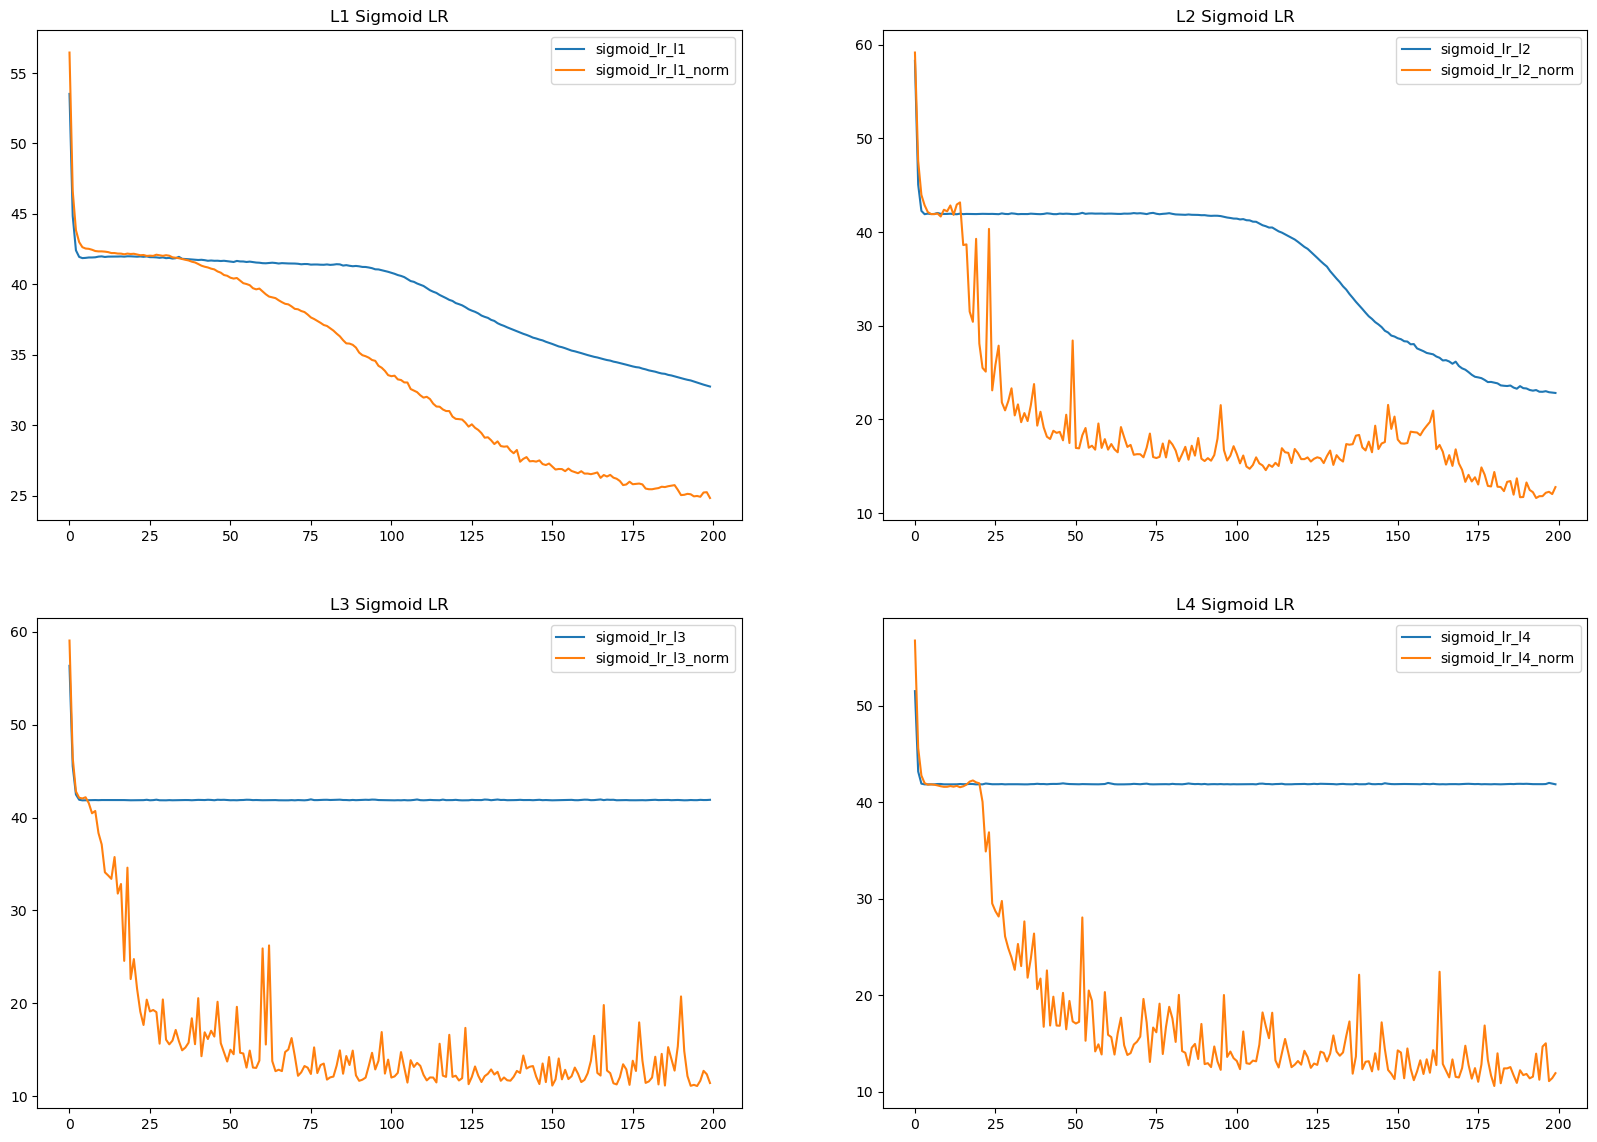

In [59]:
# 绘制测试集损失图像
plt.figure(figsize=(20, 14))
plt.subplot(221)
for idx, name in enumerate(name_list1):
    plt.plot(range(num_epochs), test_losses1[idx], label=name)
plt.title('L1 Sigmoid LR')
plt.legend()
plt.subplot(222)
for idx, name in enumerate(name_list2):
    plt.plot(range(num_epochs), test_losses2[idx], label=name)
plt.title('L2 Sigmoid LR')
plt.legend()
plt.subplot(223)
for idx, name in enumerate(name_list3):
    plt.plot(range(num_epochs), test_losses3[idx], label=name)
plt.title('L3 Sigmoid LR')
plt.legend()
plt.subplot(224)
for idx, name in enumerate(name_list4):
    plt.plot(range(num_epochs), test_losses4[idx], label=name)
plt.title('L4 Sigmoid LR')
plt.legend()
plt.show()

很明显，BN层对更加复杂模型的优化效果更好，这是因为越复杂的模型对于梯度不平稳的问题就越明显，因此BN层在解决该问题后模型效果提升就越明显。但是引入BN层后，带来了严重的不稳定性，模型效果变得更加不稳定。

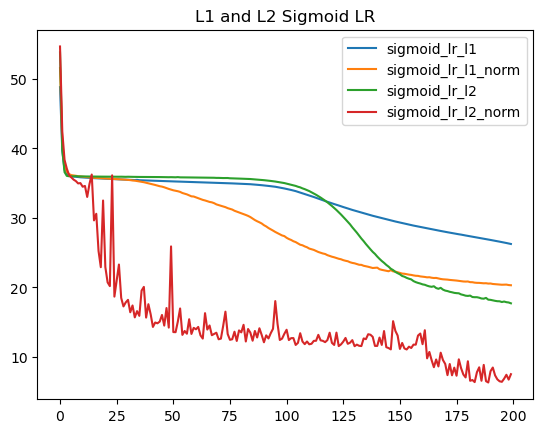

In [60]:
# 对比1层和2层Sigmoid
for idx, name in enumerate(name_list1):
    plt.plot(range(num_epochs), train_losses1[idx], label=name)
for idx, name in enumerate(name_list2):
    plt.plot(range(num_epochs), train_losses2[idx], label=name)
plt.title('L1 and L2 Sigmoid LR')
plt.legend()
plt.show()  # 在一定范围内，伴随模型复杂度提升，模型效果会有显著提升

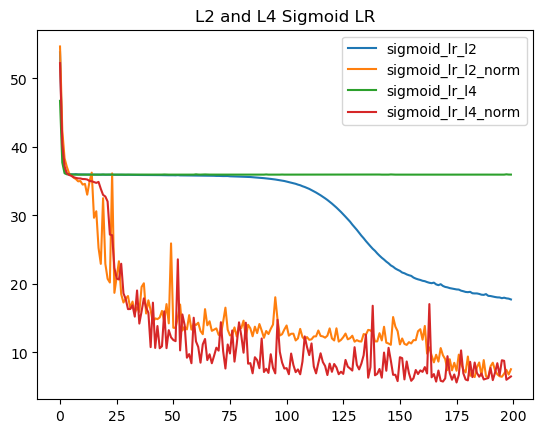

In [61]:
# 对比2层和4层Sigmoid
for idx, name in enumerate(name_list2):
    plt.plot(range(num_epochs), train_losses2[idx], label=name)
for idx, name in enumerate(name_list4):
    plt.plot(range(num_epochs), train_losses4[idx], label=name)
plt.title('L2 and L4 Sigmoid LR')
plt.legend()
plt.show()  # 当模型太过于复杂时，会出现模型效果没有提高甚至下降的情况

对于Sigmoid来说，BN层能很大程度上缓解梯度消失问题，从而提升模型收敛速度，并且小幅提升模型效果。而对于激活函数本身就能输出Zero-Centered结果的tanh函数，BN层的优化效果会更好。

Epoch: 100%|██████████| 200/200 [00:12<00:00, 16.48it/s]


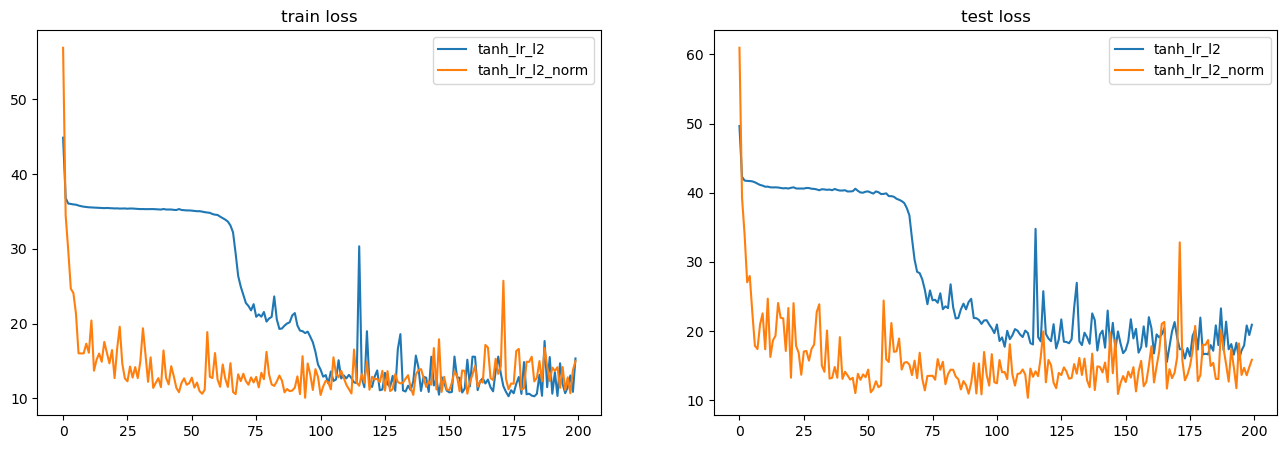

In [62]:
# 测试带2层Tanh的模型
# 超参数：学习率：0.01
lr = 0.01
num_epochs = 200

# 实例化模型
tanh_lr_l2 = L2LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l2_norm = L2LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l2, tanh_lr_l2_norm]
name_list = ['tanh_lr_l2', 'tanh_lr_l2_norm']

# 迭代训练
train_losses_001, test_losses_001 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses_001[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses_001[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

相比Sigmoid，使用Tanh激活函数本身就是更加复杂的一种选择，因此，BN层在Tanh上表现出了更好的优化效果，这也能看成是BN在复杂模型上效果有所提升。

In [63]:
# 查看带BN层的模型在训练集和测试集上最后5轮的损失均值
train_losses_001[1, -5:].mean(), test_losses_001[:, -5:].mean()

(tensor(12.6842), tensor(16.8754))

### 包含BN层的模型的学习率优化
从前面的实验可以看到，BN层对模型迭代的平稳性提升帮助不大，相反，加入BN层的模型反而可能会加剧收敛过程的，特别是对于Sigmoid激活函数来说。而收敛不平稳的模型，一般都对学习率非常敏感，也就是学习率的调整将有效缓解迭代不平稳的问题，而一旦迭代不平稳被修正，模型就有可能最后收敛到一个更优的结果。而BN层所带来的不平稳性，可以简单理解成模型可以在更大范围搜索最优解，相比不带BN层的神经网络模型，带BN层的神经网络的不平稳会更大程度受到学习率的影响。换而言之，带BN层的神经网络模型对学习率是高度敏感的，同时在进行学习率调整时能够有更大的优化空间，即在同样进行学习率调整时会有更好的效果。
#### 学习率敏感度
通过相对复杂、迭代不平稳的3层和4层Tanh模型进行实验来观测带BN层的模型对于学习率的敏感程度。

In [64]:
# 学习率0.01
# 超参数
lr = 0.01
num_epochs = 200
# 实例化模型
tanh_lr_l3 = L3LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l3_norm = L3LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')
tanh_lr_l4 = L4LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l4_norm = L4LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l3, tanh_lr_l3_norm, tanh_lr_l4, tanh_lr_l4_norm]
name_list = ['tanh_lr_l3', 'tanh_lr_l3_norm', 'tanh_lr_l4', 'tanh_lr_l4_norm']

# 迭代训练
train_losses1, test_losses1 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 学习率0.005
lr = 0.005
# 实例化模型
tanh_lr_l3 = L3LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l3_norm = L3LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')
tanh_lr_l4 = L4LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l4_norm = L4LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l3, tanh_lr_l3_norm, tanh_lr_l4, tanh_lr_l4_norm]

# 迭代训练
train_losses2, test_losses2 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 学习率0.001
lr = 0.001
# 实例化模型
tanh_lr_l3 = L3LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l3_norm = L3LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')
tanh_lr_l4 = L4LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l4_norm = L4LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l3, tanh_lr_l3_norm, tanh_lr_l4, tanh_lr_l4_norm]

# 迭代训练
train_losses3, test_losses3 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 学习率0.0001
lr = 0.0001
# 实例化模型
tanh_lr_l3 = L3LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l3_norm = L3LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')
tanh_lr_l4 = L4LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l4_norm = L4LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l3, tanh_lr_l3_norm, tanh_lr_l4, tanh_lr_l4_norm]

# 迭代训练
train_losses4, test_losses4 = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

Epoch: 100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


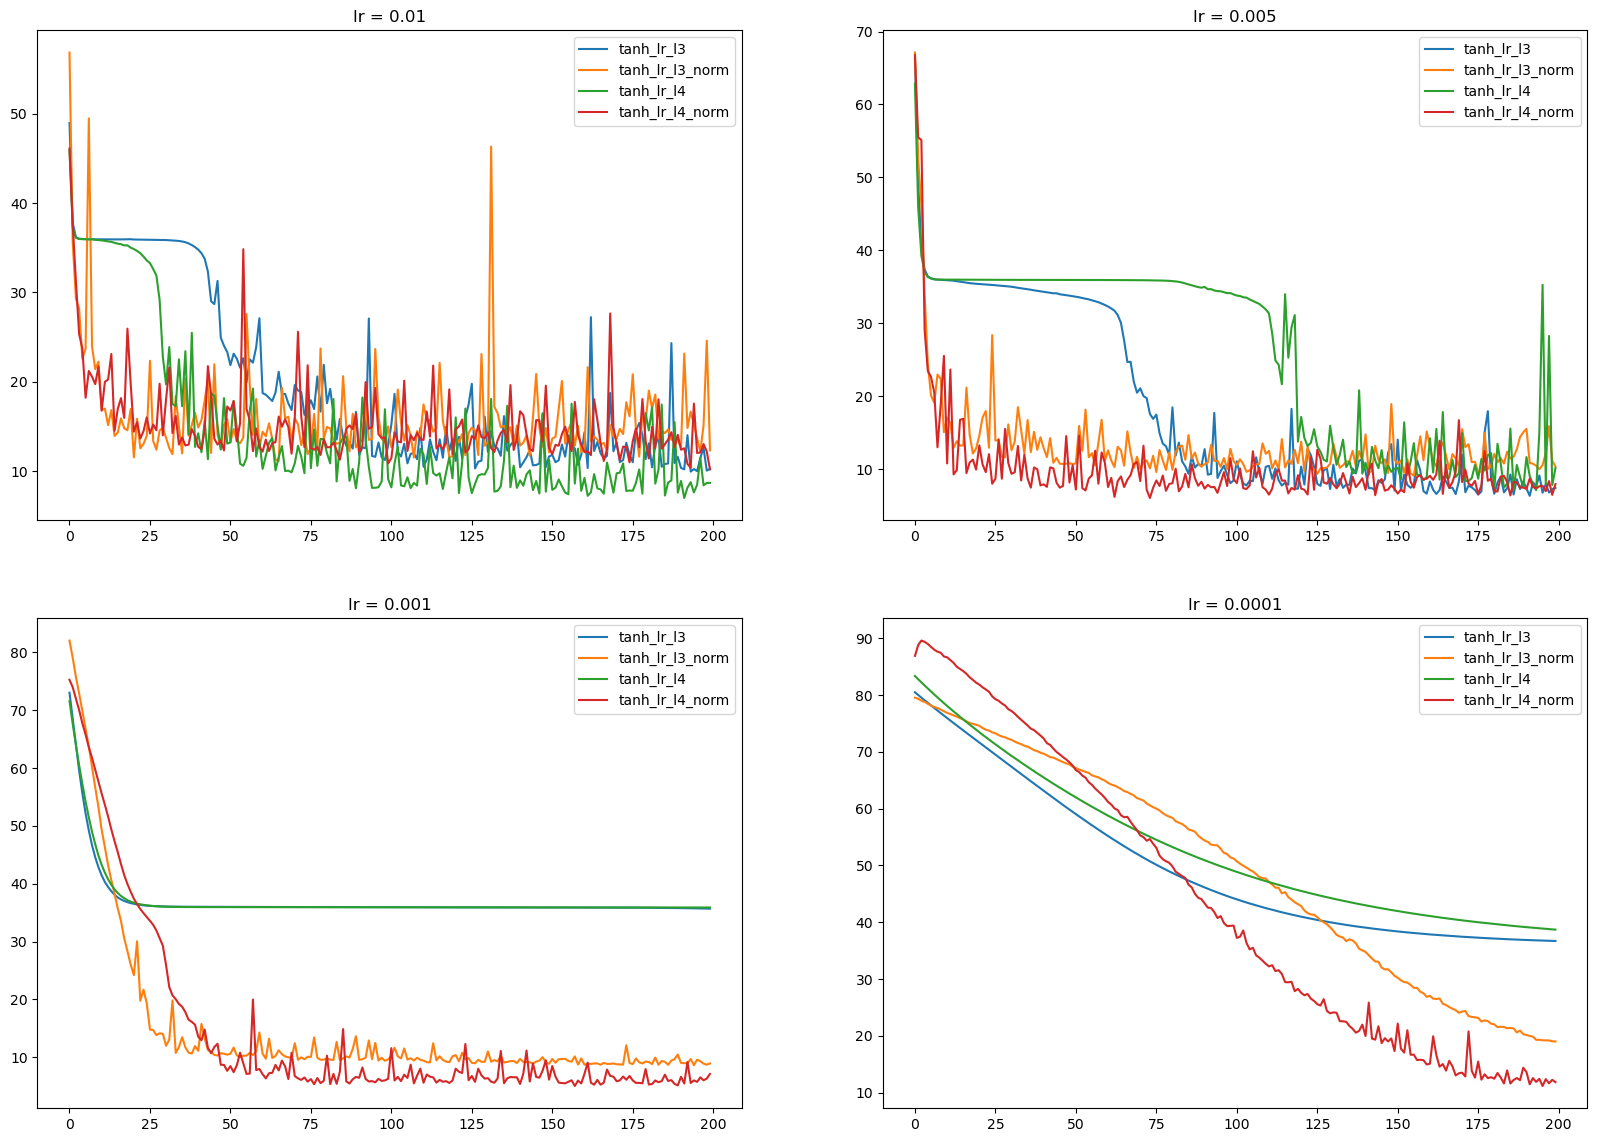

In [65]:
# 绘制训练集损失图像
plt.figure(figsize=(20, 14))
plt.subplot(221)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses1[idx], label=name)
plt.title('lr = 0.01')
plt.legend()
plt.subplot(222)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses2[idx], label=name)
plt.title('lr = 0.005')
plt.legend()
plt.subplot(223)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses3[idx], label=name)
plt.title('lr = 0.001')
plt.legend()
plt.subplot(224)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses4[idx], label=name)
plt.title('lr = 0.0001')
plt.legend()
plt.show()

可以看到，学习率为0.1时，带BN的两个模型波动很大，而学习率降低为0.005时，带BN的2个模型反而处于相对较稳定的状态，说明随着学习率逐渐变化，拥有BN层的模型表现差别很大，这也说明拥有BN层的模型对学习率变化更加敏感。BN层对学习率敏感，表明BN层可以在更大范围内进行最小值搜索，调整学习率也就拥有了更大的优化空间。
#### 学习率学习曲线
学习率作为模型重要参数，学习率的调整也会影响实际模型效果。下面探索不同的学习率下2层Tanh模型的学习效果。

Epoch: 100%|██████████| 200/200 [00:09<00:00, 20.45it/s]


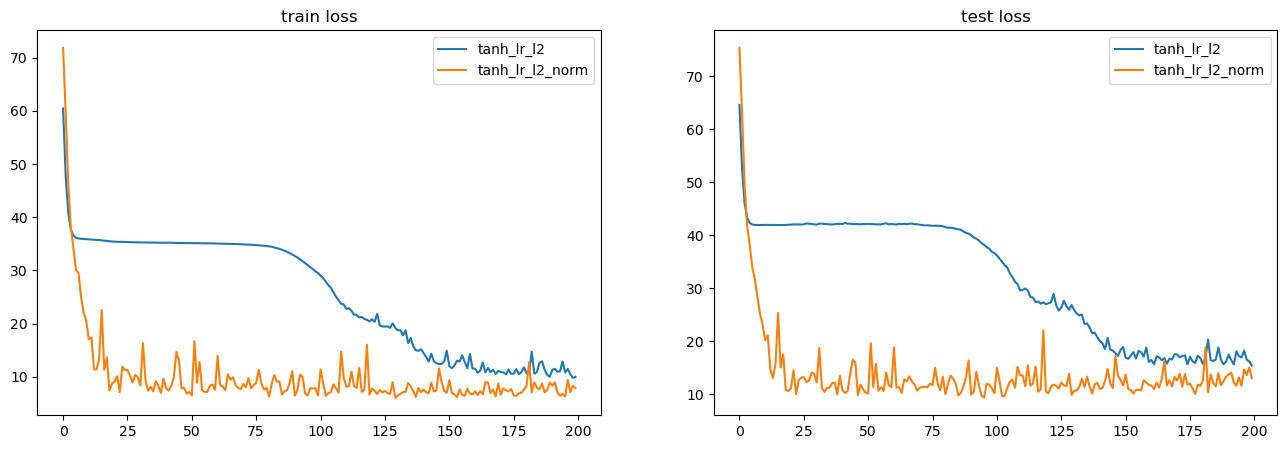

In [66]:
# 学习率0.005
lr = 0.005
num_epochs = 200

# 实例化模型
tanh_lr_l2 = L2LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l2_norm = L2LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l2, tanh_lr_l2_norm]
name_list = ['tanh_lr_l2', 'tanh_lr_l2_norm']

# 迭代训练
train_losses_0005, test_losses_0005 = compare_models(model_list, train_loader, test_loader, lr=lr,
                                                     num_epochs=num_epochs)

# 绘制损失图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses_0005[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses_0005[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

In [67]:
# 最后5轮的误差均值
train_losses_0005[1, -5:].mean(), test_losses_0005[1, -5:].mean()

(tensor(7.8234), tensor(13.5751))

可以看到，学习率调小之后模型出现了模型效果变好的情况，很大概率是因为学习率较大时，迭代到后期会出现模型迭代解在最小值点附近反复震荡而无法抵达最小值点。当调小学习率之后，迭代解就能够到达最小值点。但是学习率也不难无限小，如果学习率调得过小，不仅会降低迭代速度，同时也极有可能导致迭代解在最小值附近停止不动（每次移动步幅过小）。因此学习率学习曲线是U型曲线。下面尝试将学习率调整为0.03和0.001进行建模。

Epoch: 100%|██████████| 200/200 [00:09<00:00, 21.13it/s]


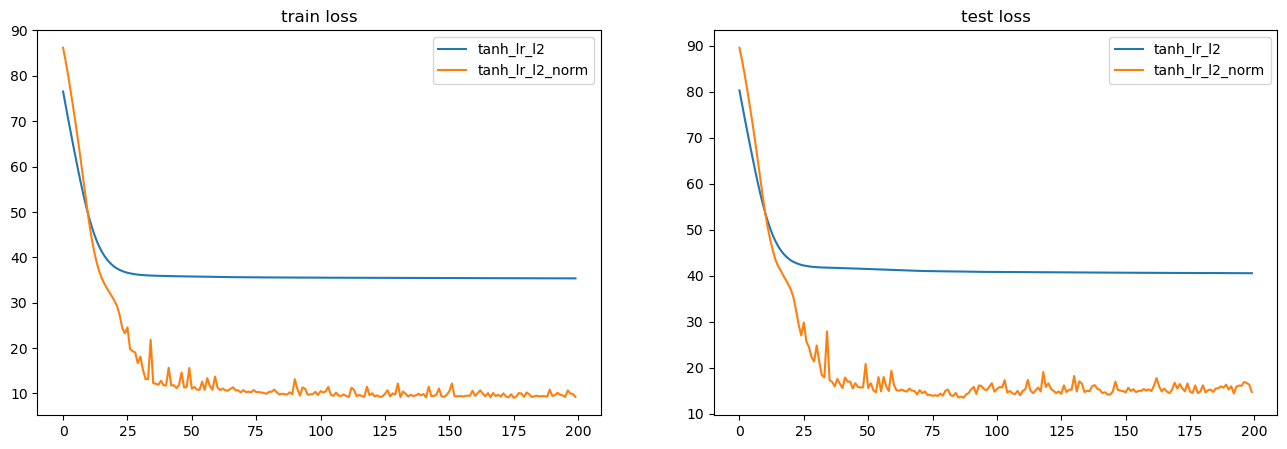

(tensor(9.8127), tensor(16.1066))

In [68]:
# 学习率0.001
# 超参数
lr = 0.001

# 实例化模型
tanh_lr_l2 = L2LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l2_norm = L2LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l2, tanh_lr_l2_norm]
name_list = ['tanh_lr_l2', 'tanh_lr_l2_norm']

# 迭代训练
train_losses_0001, test_losses_0001 = compare_models(model_list, train_loader, test_loader, lr=lr,
                                                     num_epochs=num_epochs)

# 绘制损失图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses_0001[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses_0001[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

# 最后5轮的误差均值
train_losses_0001[1, -5:].mean(), test_losses_0001[1, -5:].mean()  # 反而上升

Epoch: 100%|██████████| 200/200 [00:09<00:00, 20.72it/s]


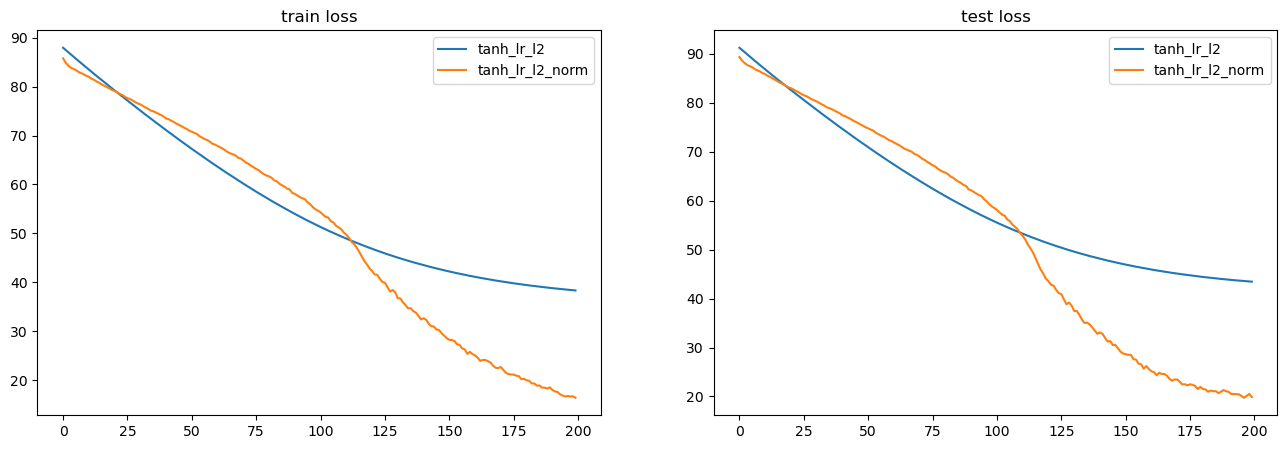

(tensor(16.6572), tensor(20.0725))

In [69]:
# 学习率0.0001
lr = 0.0001

# 实例化模型
tanh_lr_l2 = L2LRWithBN(in_features=5, activation=torch.tanh)
tanh_lr_l2_norm = L2LRWithBN(in_features=5, activation=torch.tanh, bn_mode='post')

# 模型列表
model_list = [tanh_lr_l2, tanh_lr_l2_norm]
name_list = ['tanh_lr_l2', 'tanh_lr_l2_norm']

# 迭代训练
train_losses_00001, test_losses_00001 = compare_models(model_list, train_loader, test_loader, lr=lr,
                                                       num_epochs=num_epochs)

# 绘制损失图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses_00001[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses_00001[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

# 最后5轮的误差均值
train_losses_00001[1, -5:].mean(), test_losses_00001[1, -5:].mean()  # 进一步上升

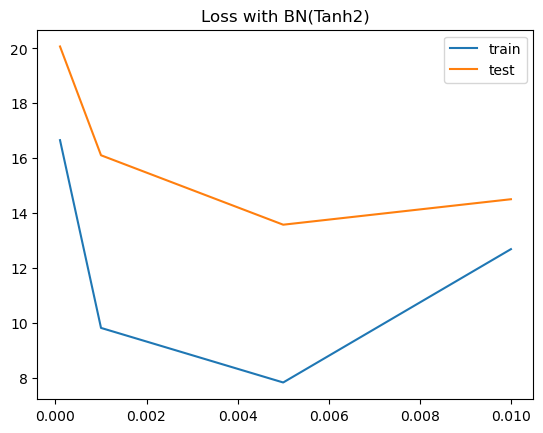

In [70]:
# 4个学习率下的损失均值可视化
lrs = [0.0001, 0.001, 0.005, 0.01]
train_loss_bn_list = [train_losses_00001[1, -5:].mean(), train_losses_0001[1, -5:].mean(),
                      train_losses_0005[1, -5:].mean(), train_losses_001[1, -5:].mean()]
test_loss_bn_list = [test_losses_00001[1, -5:].mean(), test_losses_0001[1, -5:].mean(), test_losses_0005[1, -5:].mean(),
                     test_losses_001[1, -5:].mean()]

plt.plot(lrs, train_loss_bn_list, label='train')
plt.plot(lrs, test_loss_bn_list, label='test')
plt.title('Loss with BN(Tanh2)')
plt.legend()
plt.show()

上面就是学习率的学习曲线，显然是一个倒U型曲线。在当前模型条件下，对于带BN的2层Tanh模型来说，学习率为0.005左右时模型效果较好。
### 不同学习率下不同模型的优化效果
因为学习率学习曲线是U型曲线，则U型的幅度代表着学习率对于模型的优化空间，先通过简单实验来观测不同模型的U型曲线的曲线幅度。

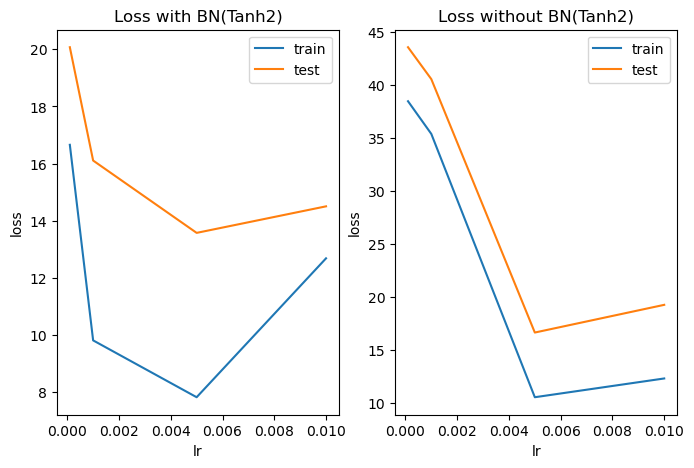

In [71]:
train_loss_list = [train_losses_00001[0, -5:].mean(), train_losses_0001[0, -5:].mean(),
                   train_losses_0005[0, -5:].mean(), train_losses_001[0, -5:].mean()]
test_loss_list = [test_losses_00001[0, -5:].mean(), test_losses_0001[0, -5:].mean(), test_losses_0005[0, -5:].mean(),
                  test_losses_001[0, -5:].mean()]

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.plot(lrs, train_loss_bn_list, label='train')
plt.plot(lrs, test_loss_bn_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss with BN(Tanh2)')
plt.legend()
plt.subplot(122)
plt.plot(lrs, train_loss_list, label='train')
plt.plot(lrs, test_loss_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss without BN(Tanh2)')
plt.legend()
plt.show()  # 带BN层的学习率优化效果比不带BN层好，都是在学习率为0.005时效果最好

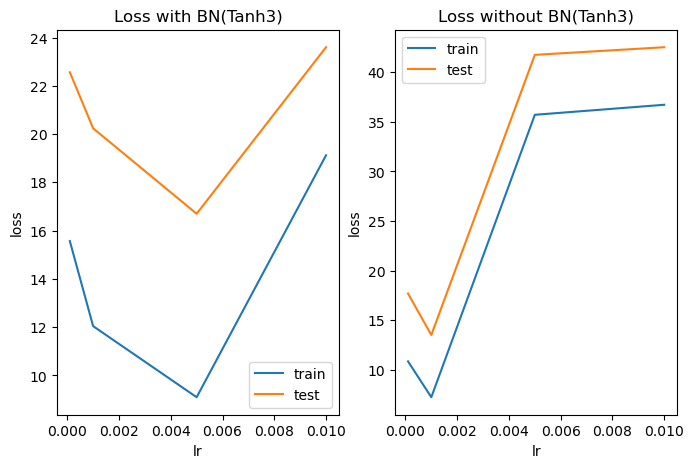

In [72]:
# 3层Tanh模型在不同学习率下的表现
train_loss_bn_list = [train_losses1[1, -5:].mean(), train_losses2[1, -5:].mean(), train_losses3[1, -5:].mean(),
                      train_losses4[1, -5:].mean()]
test_loss_bn_list = [test_losses1[1, -5:].mean(), test_losses2[1, -5:].mean(), test_losses3[1, -5:].mean(),
                     test_losses4[1, -5:].mean()]
train_loss_list = [train_losses1[0, -5:].mean(), train_losses2[0, -5:].mean(), train_losses3[0, -5:].mean(),
                   train_losses4[0, -5:].mean()]
test_loss_list = [test_losses1[0, -5:].mean(), test_losses2[0, -5:].mean(), test_losses3[0, -5:].mean(),
                  test_losses4[0, -5:].mean()]

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.plot(lrs, train_loss_bn_list, label='train')
plt.plot(lrs, test_loss_bn_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss with BN(Tanh3)')
plt.legend()
plt.subplot(122)
plt.plot(lrs, train_loss_list, label='train')
plt.plot(lrs, test_loss_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss without BN(Tanh3)')
plt.legend()
plt.show()  # 带BN与不带BN效果不同，带BN也是学习率为0.005时效果最佳

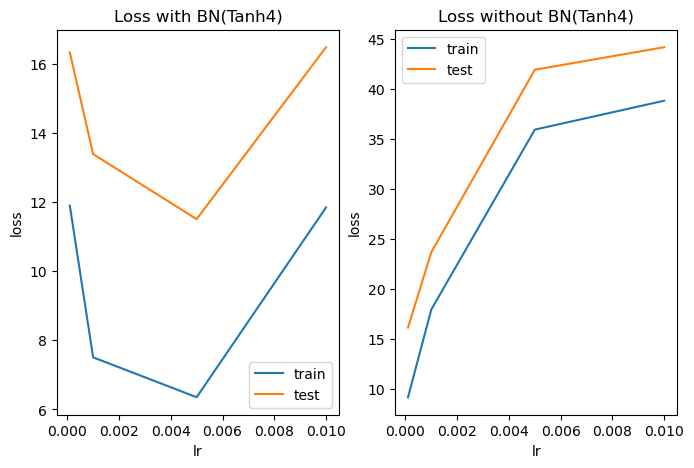

In [73]:
# 4层Tanh模型在不同学习率下的表现
train_loss_bn_list = [train_losses1[3, -5:].mean(), train_losses2[3, -5:].mean(), train_losses3[3, -5:].mean(),
                      train_losses4[3, -5:].mean()]
test_loss_bn_list = [test_losses1[3, -5:].mean(), test_losses2[3, -5:].mean(), test_losses3[3, -5:].mean(),
                     test_losses4[3, -5:].mean()]
train_loss_list = [train_losses1[2, -5:].mean(), train_losses2[2, -5:].mean(), train_losses3[2, -5:].mean(),
                   train_losses4[2, -5:].mean()]
test_loss_list = [test_losses1[2, -5:].mean(), test_losses2[2, -5:].mean(), test_losses3[2, -5:].mean(),
                  test_losses4[2, -5:].mean()]

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.plot(lrs, train_loss_bn_list, label='train')
plt.plot(lrs, test_loss_bn_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss with BN(Tanh4)')
plt.legend()
plt.subplot(122)
plt.plot(lrs, train_loss_list, label='train')
plt.plot(lrs, test_loss_list, label='test')
plt.xlabel('lr')
plt.ylabel('loss')
plt.title('Loss without BN(Tanh4)')
plt.legend()
plt.show()  # 与Tanh3结论类似

整体来看，带BN层的模型对学习率调整更加敏感，优化空间更大。BN层这种伴随模型更加复杂对学习率也更加敏感的属性，最终会使得更加复杂的模型在相同的学习率下表现更好。由上可知，带BN的4层Tanh模型在当前数据集上表现最好，并且远超不带BN的其他所有神经网络，说明**学习率调整在复杂且带BN层模型上表现效果更好**。
针对BN层的神经网络模型调参策略如下：
- 简单数据、简单模型下不用BN层，加入BN层效果并不显著
- BN层的使用需要保持running_mean和running_var的无偏性，因此需要调整batch_size，使其尽量大而又适当
- 对于带BN层模型角度来说，BN层能够帮助模型拓展优化空间，使得很多优化方法都能在原先无效的模型上生效
- 学习率是重要的模型优化的超参数，一般来说学习率学习曲线都是U型曲线，对于加入BN层的模型，学习率调整更加有效
- 对于复杂问题，在计算能力能够承担的范围内，应当首先构建带BN层的复杂模型，然后再进行优化，因为很多优化方法只对带BN层的模型有效
- 一般来说，使用BN层的模型不再会用Xavier和Kaiming等参数初始化方法，从理论上来看添加BN层能够起到参数初始化的相等效果，带BN层模型一般也不需要使用Dropout方法
- 对于ReLU叠加的模型来说，加入BN层之后能够有效缓解Dead ReLU Problem，此时无须刻意调小学习率，能够在收敛速度和运算结果间保持较好的平衡